In [224]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pylab
from pathlib import Path
import winsound
import xarray as xr
from e6dataflow.datamodel import load_datamodel
from e6dataflow.utils import shot_to_loop_and_point, scale_range
from e6dataflow.tools.fittools import e6_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
datamodel_dir = Path.cwd()
fig_directory = Path(datamodel_dir, 'analysis_figures')
fig_data_directory = Path(datamodel_dir, 'analysis_figures_data')
fig_directory.mkdir(exist_ok=True)
fig_data_directory.mkdir(exist_ok=True)
datamodel = load_datamodel(run_name='run1', datamodel_name='datamodel_jag')
print('run_doc_string:\n' + datamodel.run_doc_string)

Loading datamodel from Y:\expdata-e6\analysis\2021\02\21\run1\datamodel_jag\run1-datamodel_jag.p


TypeError: super(type, obj): obj must be an instance or subtype of type

In [57]:
def freq_volt_to_baredet(freq_volt):
    # Returning detuning in MHz
    return freq_volt * 13.69 - 126.4
def freq_volt_to_det(freq_volt, tweezer_det):
    # Returning detuning in MHz
    return freq_volt_to_baredet(freq_volt) - tweezer_det

In [81]:
# Run information
mol_freq_list = [4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9]
mol_freq_list = freq_volt_to_baredet(np.array(mol_freq_list))
gamma = 6.07
tweezer_det = 5.88*gamma
mol_freq_list_wrt_tweezer = mol_freq_list - tweezer_det
num_mol_freq = len(mol_freq_list)
num_frames = num_mol_freq + 2 # One extra frame for post-selection of final frame, one reference frame.

tweezer_list = [108, 110, 112, 114, 116]
num_tweezer = len(tweezer_list)

pzt_list = [5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
num_pzt = len(pzt_list)

odt_att_list = [0.2, 0.4, 0.6, 0.8, 1]
num_odt_att = len(odt_att_list)

num_points = datamodel.num_points
num_shots = datamodel.num_handled_shots
num_loops_complete = num_shots // num_points

print(num_points, 'points')
print(num_frames, 'frames')
print(num_tweezer, 'tweezers')
print(num_shots, 'shots')
print(num_loops_complete, 'complete loops')
if num_shots % num_points != 0:
    num_loops = num_loops_complete + 1
    print('1 incomplete loop')
else:
    num_loops = num_loops_complete
    print('0 incomplete loops')


coords_list = [('loop', range(num_loops)),
               ('mol_freq', mol_freq_list),
               ('tweezer', tweezer_list),
               ('pzt', pzt_list),
               ('odt_att', odt_att_list)]

50 points
12 frames
5 tweezers
8825 shots
176 complete loops
1 incomplete loop


In [71]:
def frame_tweezer_key(frame_num, tweezer_num):
    return f'frame-{frame_num:02d}_tweezer-{tweezer_num:02d}'

def pzt_and_odt_to_point(pzt_num, odt_num, num_pzt, num_odt):
    if odt_num >= num_odt:
        raise ValueError('odt_num cannot exceed num_odt')
    if pzt_num >= num_pzt:
        raise ValueError('pzt_num cannot exceed num_pzt')        
    return pzt_num * num_odt + odt_num

def point_to_pzt_and_odt(point_num, num_pzt, num_odt):
    pzt_num = point_num // num_odt
    odt_num = point_num % num_odt
    return pzt_num, odt_num

def gaussian(x, x0, amp, sigma):
    return amp * np.exp(-(1 / 2) * (x - x0)**2 / sigma**2)

def double_gaussian(x, x0_1, amp_1, sigma_1, x0_2, amp_2, sigma_2):
    return gaussian(x, x0_1, amp_1, sigma_1) + gaussian(x, x0_2, amp_2, sigma_2)

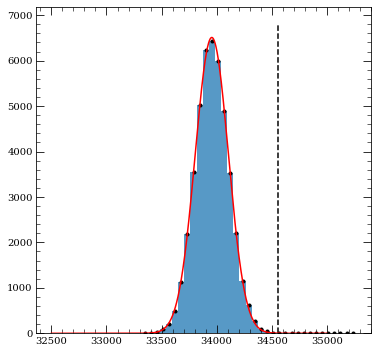

Reference data centered at 33956 counts with standard deviation 150
3-sigma threshold at 34557


In [72]:
# Analyze reference frame
ref_frame_num = 11
ref_counts_list = []
for tweezer_num in range(num_tweezer):
    data_key = frame_tweezer_key(ref_frame_num, tweezer_num)
    data_key = f'{data_key}_counts'
    ref_counts_data = datamodel.get_data(data_key, data_index='all')
    ref_counts_list += list(ref_counts_data)

fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(1, 1, 1)
n, bins, patches = ax.hist(ref_counts_list, bins=35, alpha=0.75)
bin_centers = (bins[1:] + bins[:-1]) / 2

ax.plot(bin_centers, n, '.', color='black')

fit_dict = e6_fit(output_data=n, input_data=bin_centers, fit_func=gaussian, 
                  param_guess=[19000, 40, 5000],
                  param_keys=['x0', 'amp', 'sigma'])

model_input = np.linspace(32500, 35000, 1000)
model_output = gaussian(model_input, *fit_dict['kwargs'].values())
ax.plot(model_input, model_output, color='red')

ref_center = fit_dict['x0']['val']
ref_sigma = np.abs(fit_dict['sigma']['val'])
ref_threshold = ref_center +4 * ref_sigma
ax.vlines(ref_threshold, 0, ax.get_ylim()[1], linestyle='--')
plt.show()
print(f'Reference data centered at {ref_center:.0f} counts with standard deviation {ref_sigma:.0f}')
print(f'3-sigma threshold at {ref_threshold:.0f}')

In [73]:
brightness_xr = xr.DataArray(coords=coords_list)

for shot_num in range(num_shots):
    if shot_num % 500 == 0:
        print(shot_num)
    for freq_num in range(num_mol_freq):
        for tweezer_num in range(num_tweezer):
            loop_num, point_num = shot_to_loop_and_point(shot_num, num_points=num_points)
            pzt_num, odt_att_num = point_to_pzt_and_odt(point_num, num_pzt, num_odt_att)
#             title_key = (f'freq_num: {freq_num}, odt_att_num: {odt_att_num}, '
#                          f'tweezer_num: {tweezer_num}, pzt_num: {pzt_num}, '
#                          f'point_num: {point_num}, loop_num: {loop_num}')
            data_key = frame_tweezer_key(frame_num=freq_num, tweezer_num=tweezer_num)
            data = datamodel.get_data(f'{data_key}_counts', data_index=shot_num)
            next_data_key = frame_tweezer_key(frame_num=freq_num + 1, tweezer_num=tweezer_num)
            next_data = datamodel.get_data(f'{next_data_key}_counts', data_index=shot_num)
            if data > ref_center + 1 * ref_sigma and next_data > ref_center + 3 * ref_sigma:
                brightness_xr[loop_num, freq_num, tweezer_num, pzt_num, odt_att_num] = data - ref_center

winsound.PlaySound("SystemAsterisk", winsound.SND_ALIAS)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500


In [74]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

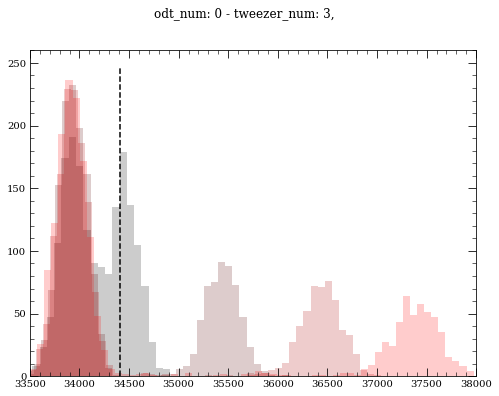

In [291]:
next_para = 3
this_para = 1
for odt_att_num in range(0, 1):
    for tweezer_num in range(3,4):
        fig = plt.figure(figsize=(8, 6))
        ax_hist = fig.add_subplot(1, 1, 1)
        
#         for freq_num in range(0,num_mol_freq,2):             
        
        for freq_counter, freq_num in enumerate([0,6,8,9]):             
            title_key = (f'odt_num: {odt_att_num} - '
                         f'tweezer_num: {tweezer_num}, ')
            data_key = frame_tweezer_key(frame_num=freq_num, tweezer_num=tweezer_num)
            data_all = np.array([])
            for pzt_num in range(num_pzt):
                point_num = pzt_and_odt_to_point(pzt_num, odt_att_num, num_pzt, num_odt_att)
                data = np.array(datamodel.get_data_by_point(f'{data_key}_counts', point_num=point_num))
#                 next_data_key = frame_tweezer_key(frame_num=freq_num + 1, tweezer_num=tweezer_num)
#                 next_data = np.array(datamodel.get_data_by_point(f'{next_data_key}_counts', point_num=point_num))
                data_all = np.append(data_all, data)
#             data_post_2 = np.copy(data)
#             data_post_2[np.logical_or(data < ref_center + 1 * ref_sigma, next_data < ref_center + 3 * ref_sigma)] = np.nan
            
            
            n, bins, patches = ax_hist.hist(data_all, bins=int((max(data_all)-min(data_all))/70), \
                                            color=lighten_color('r', 2 - freq_counter/3), alpha=0.2)
#             ax_hist.hist(data_post, color='black', bins=bins, alpha=0.5)

        fig.suptitle(title_key)
        ax_hist.set_xlim(33500, 38000)
        ax_hist.vlines(ref_center + next_para * ref_sigma, 0, ax_hist.get_ylim()[1], linestyle='--')

            
#         if tweezer_num == 4:
        plt.show()
            
#             save_dir = Path(fig_directory, f'point_num - {point_num}', f'freq_num - {freq_num}')
#             save_dir.mkdir(parents=True, exist_ok=True)
#             file_name = f'point_num - {point_num} -- freq_num - {freq_num} -- tweezer_num - {tweezer_num} -- counts.png'
#             file_path = Path(save_dir, file_name)
#             fig.savefig(file_path)
#             plt.close(fig)


33955.94152494904


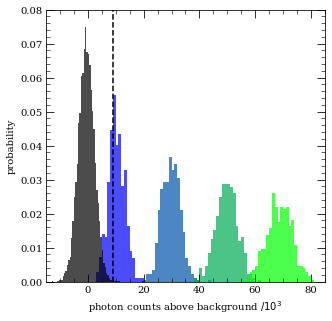

In [401]:
next_para = 3
this_para = 1
plot_range = (-15,85)
plot_range_abs = plot_range[1] - plot_range[0]
camera_adu_conversion = 1000 / 0.28 
path_efficiency_estimate = 0.014
color_list = [(0, element/3, 1-element/3) for element in range(0,4)]
print(ref_center)
for odt_att_num in range(0, 1):
    for tweezer_num in range(3,4):
        fig = plt.figure(figsize=(5, 5))
        ax_hist = fig.add_subplot(1, 1, 1)
        
#         for freq_num in range(0,num_mol_freq,2):             
        dat_out_dict = {}
        freq_select = [0,6,8,9]  
        freq_next_select = [1,7,9,10]
        for freq_counter, freq_num in enumerate(freq_select):
            if freq_counter > 1:
                this_para = 4
            title_key = (f'odt_num: {odt_att_num} - '
                         f'tweezer_num: {tweezer_num}, ')
            data_key = frame_tweezer_key(frame_num=freq_num, tweezer_num=tweezer_num)
            next_data_key = frame_tweezer_key(frame_num=freq_next_select[freq_counter], tweezer_num=tweezer_num)
            data_post_all = np.array([])
            for pzt_num in range(num_pzt):
                point_num = pzt_and_odt_to_point(pzt_num, odt_att_num, num_pzt, num_odt_att)
                data = np.array(datamodel.get_data_by_point(f'{data_key}_counts', point_num=point_num)) - ref_center
                next_data = np.array(datamodel.get_data_by_point(f'{next_data_key}_counts', point_num=point_num))- ref_center
                data_post = data[np .logical_and(data > this_para * ref_sigma, next_data > next_para * ref_sigma)]/(camera_adu_conversion*path_efficiency_estimate)
                data_post_all = np.append(data_post_all, data_post)
#             
            
#             n, bins, patches = ax_hist.hist(data_post_all*camera_adu_conversion, bins=int((max(data_post_all)-min(data_post_all))/70), \
#                                             color=color_list[freq_counter], alpha=0.7)
            n, bins, patches = ax_hist.hist(data_post_all, bins=plot_range_abs, \
                                            range=plot_range, color=color_list[freq_counter], alpha=0.7)
            dat_out_dict[f'mol_freq_det={mol_freq_list[freq_num]}'] = data_post_all
#             ax_hist.hist(data_post, color='black', bins=bins, alpha=0.5)
            for item in patches:
                item.set_height(item.get_height()/(num_pzt*num_loops))
        data_key = frame_tweezer_key(ref_frame_num, tweezer_num=tweezer_num)
        ref_counts_data = (datamodel.get_data(f'{data_key}_counts', data_index='all') - ref_center)/(camera_adu_conversion*path_efficiency_estimate)
        n, bins, patches = ax_hist.hist(ref_counts_data, bins=2*plot_range_abs, \
                                            range=plot_range, color='black', alpha=0.7, density=True)
        
        dat_out_dict[f'reference_frame'] = ref_counts_data
        for item in patches:
            item.set_height(item.get_height()/sum(n))

#         fig.suptitle(title_key)
        ax_hist.set_xlim(plot_range)
        ax_hist.set_ylim(0, 0.08)
        ax_hist.vlines(next_para*ref_sigma /(camera_adu_conversion*path_efficiency_estimate), 0, ax_hist.get_ylim()[1], linestyle='--')

        ax_hist.set_ylabel('probability')
        ax_hist.set_xlabel('photon counts above background $/10^3$')
            
#         if tweezer_num == 4:
        plt.show()
        save_dir = Path(fig_directory)
        save_dir.mkdir(parents=True, exist_ok=True)
        file_name = f'figure - 2a - withref.png'
        file_path = Path(save_dir, file_name)
        fig.savefig(file_path, dpi=500)
        plt.close(fig)
        
        fig_data_directory = Path(datamodel_dir, 'analysis_figures_data')
        import csv
        save_data_dir = Path(fig_data_directory)
        file_name = 'figure - 2a - withref.csv'
        dat_file_path = Path(save_data_dir, file_name)
        with open(dat_file_path, 'w') as csv_file:
            csv_writer = csv.writer(csv_file, delimiter=',')
            csv_writer0 = csv.writer(csv_file, delimiter=' ')
            for key in dat_out_dict:
                csv_writer0.writerow(key)
                csv_writer.writerow(dat_out_dict[key])

33955.94152494904


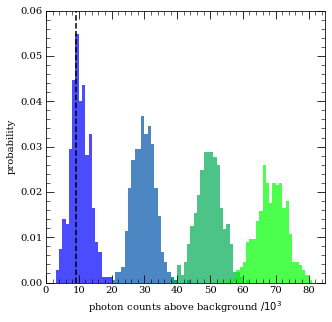

In [402]:
next_para = 3
this_para = 1
plot_range = (0,85)
plot_range_abs = plot_range[1] - plot_range[0]
camera_adu_conversion = 1000 / 0.28 
path_efficiency_estimate = 0.014
color_list = [(0, element/3, 1-element/3) for element in range(0,4)]
print(ref_center)
for odt_att_num in range(0, 1):
    for tweezer_num in range(3,4):
        fig = plt.figure(figsize=(5, 5))
        ax_hist = fig.add_subplot(1, 1, 1)
        
#         for freq_num in range(0,num_mol_freq,2):             
        dat_out_dict = {}
        freq_select = [0,6,8,9]  
        freq_next_select = [1,7,9,10]
        for freq_counter, freq_num in enumerate(freq_select):
            if freq_counter > 1:
                this_para = 4
            title_key = (f'odt_num: {odt_att_num} - '
                         f'tweezer_num: {tweezer_num}, ')
            data_key = frame_tweezer_key(frame_num=freq_num, tweezer_num=tweezer_num)
            next_data_key = frame_tweezer_key(frame_num=freq_next_select[freq_counter], tweezer_num=tweezer_num)
            data_post_all = np.array([])
            for pzt_num in range(num_pzt):
                point_num = pzt_and_odt_to_point(pzt_num, odt_att_num, num_pzt, num_odt_att)
                data = np.array(datamodel.get_data_by_point(f'{data_key}_counts', point_num=point_num)) - ref_center
                next_data = np.array(datamodel.get_data_by_point(f'{next_data_key}_counts', point_num=point_num))- ref_center
                data_post = data[np .logical_and(data > this_para * ref_sigma, next_data > next_para * ref_sigma)] /(camera_adu_conversion*path_efficiency_estimate)
                data_post_all = np.append(data_post_all, data_post)
#             
            
#             n, bins, patches = ax_hist.hist(data_post_all*camera_adu_conversion, bins=int((max(data_post_all)-min(data_post_all))/70), \
#                                             color=color_list[freq_counter], alpha=0.7)
            n, bins, patches = ax_hist.hist(data_post_all, bins=plot_range_abs, \
                                            range=plot_range, color=color_list[freq_counter], alpha=0.7)
            dat_out_dict[f'mol_freq_det={mol_freq_list[freq_num]}'] = data_post_all
#             ax_hist.hist(data_post, color='black', bins=bins, alpha=0.5)
            for item in patches:
                item.set_height(item.get_height()/(num_pzt*num_loops))
#         data_key = frame_tweezer_key(ref_frame_num, tweezer_num=tweezer_num)
#         ref_counts_data = datamodel.get_data(f'{data_key}_counts', data_index='all') - ref_center
#         n, bins, patches = ax_hist.hist(ref_counts_data*camera_adu_conversion, bins=int((max(ref_counts_data)-min(ref_counts_data))/70), \
#                                         color='black', alpha=0.7, density=True)
#         for item in patches:
#             item.set_height(item.get_height()/sum(n))

#         fig.suptitle(title_key)
        ax_hist.set_xlim(plot_range)
        ax_hist.set_ylim(0, 0.06)
        ax_hist.vlines(next_para * ref_sigma/(camera_adu_conversion*path_efficiency_estimate), 0, ax_hist.get_ylim()[1], linestyle='--')

        ax_hist.set_ylabel('probability')
        ax_hist.set_xlabel('photon counts above background $/10^3$')
            
#         if tweezer_num == 4:
        plt.show()
        save_dir = Path(fig_directory)
        save_dir.mkdir(parents=True, exist_ok=True)
        file_name = f'figure - 2a.png'
        file_path = Path(save_dir, file_name)
        fig.savefig(file_path, dpi=500)
        plt.close(fig)
        
        fig_data_directory = Path(datamodel_dir, 'analysis_figures_data')
        import csv
        save_data_dir = Path(fig_data_directory)
        file_name = 'figure - 2a.csv'
        dat_file_path = Path(save_data_dir, file_name)
        with open(dat_file_path, 'w') as csv_file:
            csv_writer = csv.writer(csv_file, delimiter=',')
            csv_writer0 = csv.writer(csv_file, delimiter=' ')
            for key in dat_out_dict:
                csv_writer0.writerow(key)
                csv_writer.writerow(dat_out_dict[key])

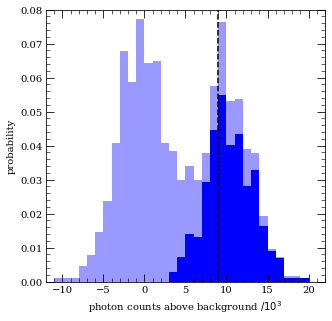

In [403]:
next_para = 3
this_para = 1
plot_range = (-12,22)
plot_range_abs = plot_range[1] - plot_range[0]
camera_adu_conversion = 1000 / 0.28 
path_efficiency_estimate = 0.014
color_list = ['blue', 'cyan']
for odt_att_num in range(0,1):
    for tweezer_num in range(3,4):
        fig = plt.figure(figsize=(5, 5))
        ax_hist = fig.add_subplot(1, 1, 1)
        
#         for freq_num in range(0,num_mol_freq,2):             
        freq_select = [0]       
        freq_next_select = [1]        
        dat_out_dict = {}
        for freq_counter, freq_num in enumerate(freq_select):             
            title_key = (f'odt_num: {odt_att_num} - '
                         f'tweezer_num: {tweezer_num}, ')
            data_key = frame_tweezer_key(frame_num=freq_num, tweezer_num=tweezer_num)
            data_post_all = np.array([])
            data_all = np.array([])
            for pzt_num in range(num_pzt):
                point_num = pzt_and_odt_to_point(pzt_num, odt_att_num, num_pzt, num_odt_att)
                data = np.array(datamodel.get_data_by_point(f'{data_key}_counts', point_num=point_num)) - ref_center
#                 next_data_key = frame_tweezer_key(frame_num=freq_num + 1, tweezer_num=tweezer_num)
                next_data_key = frame_tweezer_key(frame_num=freq_next_select[freq_counter], tweezer_num=tweezer_num)
                next_data = np.array(datamodel.get_data_by_point(f'{next_data_key}_counts', point_num=point_num)) - ref_center
                data_post = data[np .logical_and(data > this_para * ref_sigma, next_data > next_para * ref_sigma)]
                data_all = np.append(data_all, data/(camera_adu_conversion*path_efficiency_estimate))
                data_post_all = np.append(data_post_all, data_post/(camera_adu_conversion*path_efficiency_estimate))
#             data_post_2 = np.copy(data)
#             data_post_2[np.logical_or(data < ref_center + 1 * ref_sigma, next_data < ref_center + 3 * ref_sigma)] = np.nan
            
            
            dat_out_dict[f'mol_freq_det={mol_freq_list[freq_num]}_raw'] = data_all
            n, bins, patches = ax_hist.hist(data_all, bins=plot_range_abs, \
                                            range=plot_range,   color  = color_list[freq_counter], alpha=0.4, label = f'{mol_freq_list[freq_num]/gamma:.1f} (raw data)')
            
            for item in patches:
                item.set_height(item.get_height()/(num_pzt*num_loops))
                
            dat_out_dict[f'mol_freq_det={mol_freq_list[freq_num]}_post_selected'] = data_post_all
            n, bins, patches = ax_hist.hist(data_post_all, bins=plot_range_abs, \
                                            range=plot_range, color  = color_list[freq_counter], alpha=1, label = f'{mol_freq_list[freq_num]/gamma:.1f} (post selected)')
#             ax_hist.hist(data_post, color='black', bins=bins, alpha=0.5)

            for item in patches:
                item.set_height(item.get_height()/(num_pzt*num_loops))
#         data_key = frame_tweezer_key(ref_frame_num, tweezer_num=tweezer_num)
#         ref_counts_data = datamodel.get_data(f'{data_key}_counts', data_index='all') - ref_center
#         n, bins, patches = ax_hist.hist(ref_counts_data*camera_adu_conversion, bins=30, \
#                                             range=(-2,4), color='black', alpha=0.7, density=True)
#         for item in patches:
#             item.set_height(item.get_height()/sum(n))
#         fig.suptitle(title_key)
        ax_hist.set_xlim(plot_range)
        ax_hist.set_ylim(0, 0.08)
        ax_hist.vlines(next_para * ref_sigma/(camera_adu_conversion*path_efficiency_estimate), 0, ax_hist.get_ylim()[1], linestyle='--')
#         ax_hist.legend(title='Molasses bare detuning $\Delta/\Gamma$', bbox_to_anchor=(1, 1), loc='upper right')
        ax_hist.set_ylabel('probability')
        ax_hist.set_xlabel('photon counts above background $/10^3$')
            
            
#         if tweezer_num == 4:
        plt.show()
        save_dir = Path(fig_directory)
        save_dir.mkdir(parents=True, exist_ok=True)
        file_name = f'figure - 2a(inset).png'
        file_path = Path(save_dir, file_name)
        fig.savefig(file_path, dpi=500)
        plt.close(fig)
        
        fig_data_directory = Path(datamodel_dir, 'analysis_figures_data')
        import csv
        save_data_dir = Path(fig_data_directory)
        file_name = 'figure - 2a(inset).csv'
        dat_file_path = Path(save_data_dir, file_name)
        with open(dat_file_path, 'w') as csv_file:
            csv_writer = csv.writer(csv_file, delimiter=',')
            csv_writer0 = csv.writer(csv_file, delimiter=' ')
            for key in dat_out_dict:
                csv_writer0.writerow(key)
                csv_writer.writerow(dat_out_dict[key])

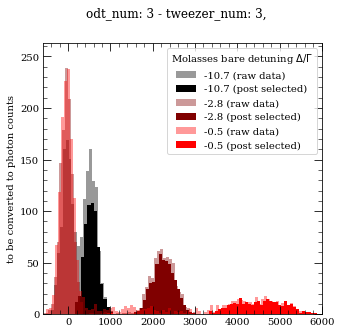

In [262]:
next_para = 4
this_para = 1
for odt_att_num in range(3,4):
    for tweezer_num in range(3,4):
        fig = plt.figure(figsize=(5,5))
        ax_hist = fig.add_subplot(1, 1, 1)
        
#         for freq_num in range(0,num_mol_freq,2):             
        freq_select = [0,7,9]       
        freq_next_select = [7,9,10]
        for freq_counter, freq_num in enumerate(freq_select):             
            title_key = (f'odt_num: {odt_att_num} - '
                         f'tweezer_num: {tweezer_num}, ')
            data_key = frame_tweezer_key(frame_num=freq_num, tweezer_num=tweezer_num)
            data_post_all = np.array([])
            data_all = np.array([])
            for pzt_num in range(num_pzt):
                point_num = pzt_and_odt_to_point(pzt_num, odt_att_num, num_pzt, num_odt_att)
                data = np.array(datamodel.get_data_by_point(f'{data_key}_counts', point_num=point_num))- ref_center
#                 next_data_key = frame_tweezer_key(frame_num=freq_num + 1, tweezer_num=tweezer_num)
                next_data_key = frame_tweezer_key(frame_num=freq_next_select[freq_counter], tweezer_num=tweezer_num)
                next_data = np.array(datamodel.get_data_by_point(f'{next_data_key}_counts', point_num=point_num)) - ref_center
                data_post = data[np .logical_and(data > this_para * ref_sigma, next_data > next_para * ref_sigma)]
                data_all = np.append(data_all, data)
                data_post_all = np.append(data_post_all, data_post)
#             data_post_2 = np.copy(data)
#             data_post_2[np.logical_or(data < ref_center + 1 * ref_sigma, next_data < ref_center + 3 * ref_sigma)] = np.nan
            
            
            n, bins, patches = ax_hist.hist(data_all, bins=int((max(data_all)-min(data_all))/70), \
                                            color=lighten_color('r', 2 - freq_counter/2), alpha=0.4, label = f'{mol_freq_list[freq_num]/gamma:.1f} (raw data)')
            n, bins, patches = ax_hist.hist(data_post_all, bins=int((max(data_post_all)-min(data_post_all))/70), \
                                            color=lighten_color('r', 2 - freq_counter/2), alpha=1, label = f'{mol_freq_list[freq_num]/gamma:.1f} (post selected)')
#             ax_hist.hist(data_post, color='black', bins=bins, alpha=0.5)

        fig.suptitle(title_key)
        ax_hist.set_xlim(-600, 6000)
        ax_hist.vlines(ref_center + next_para * ref_sigma, 0, ax_hist.get_ylim()[1], linestyle='--')
        ax_hist.legend(title='Molasses bare detuning $\Delta/\Gamma$', bbox_to_anchor=(1, 1), loc='upper right')
        ax_hist.set_ylabel('number of shots')
        ax_hist.set_ylabel('to be converted to photon counts')

            
#         if tweezer_num == 4:
        plt.show()
        save_dir = Path(fig_directory)
        save_dir.mkdir(parents=True, exist_ok=True)
        file_name = f'figure -- odt_num - {odt_att_num}tweezer_num - {tweezer_num} -- counts.png'
        file_path = Path(save_dir, file_name)
        fig.savefig(file_path, dpi=500)
        plt.close(fig)


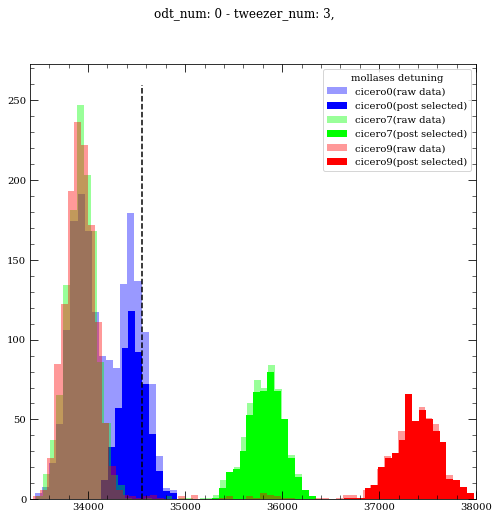

In [92]:
import colorsys
next_para = 4
this_para = 1
for odt_att_num in range(0, 1):
    for tweezer_num in range(3,4):
        fig = plt.figure(figsize=(8, 8))
        ax_hist = fig.add_subplot(1, 1, 1)
        
#         for freq_num in range(0,num_mol_freq,2):             
        freq_select = [0,7,9]       
        freq_next_select = [7,9,10]
        for freq_counter, freq_num in enumerate(freq_select):             
            title_key = (f'odt_num: {odt_att_num} - '
                         f'tweezer_num: {tweezer_num}, ')
            data_key = frame_tweezer_key(frame_num=freq_num, tweezer_num=tweezer_num)
            data_post_all = np.array([])
            data_all = np.array([])
            for pzt_num in range(num_pzt):
                point_num = pzt_and_odt_to_point(pzt_num, odt_att_num, num_pzt, num_odt_att)
                data = np.array(datamodel.get_data_by_point(f'{data_key}_counts', point_num=point_num))
#                 next_data_key = frame_tweezer_key(frame_num=freq_num + 1, tweezer_num=tweezer_num)
                next_data_key = frame_tweezer_key(frame_num=freq_next_select[freq_counter], tweezer_num=tweezer_num)
                next_data = np.array(datamodel.get_data_by_point(f'{next_data_key}_counts', point_num=point_num))
                data_post = data[np .logical_and(data > ref_center + this_para * ref_sigma, next_data > ref_center + next_para * ref_sigma)]
                data_all = np.append(data_all, data)
                data_post_all = np.append(data_post_all, data_post)
#             data_post_2 = np.copy(data)
#             data_post_2[np.logical_or(data < ref_center + 1 * ref_sigma, next_data < ref_center + 3 * ref_sigma)] = np.nan
            
            
            color = colorsys.hsv_to_rgbc
            n, bins, patches = ax_hist.hist(data_all, bins=int((max(data_all)-min(data_all))/70), \
                                            color=color, alpha=0.4, label = f'cicero{freq_num}(raw data)')
            n, bins, patches = ax_hist.hist(data_post_all, bins=int((max(data_post_all)-min(data_post_all))/70), \
                                            color=color, alpha=1, label = f'cicero{freq_num}(post selected)')
#             ax_hist.hist(data_post, color='black', bins=bins, alpha=0.5)

        fig.suptitle(title_key)
        ax_hist.set_xlim(33400, 38000)
        ax_hist.vlines(ref_center + next_para * ref_sigma, 0, ax_hist.get_ylim()[1], linestyle='--')
        ax_hist.legend(title='Molasses detuning', bbox_to_anchor=(1, 1), loc='upper right')
            
#         if tweezer_num == 4:
        plt.show()
            
#             save_dir = Path(fig_directory, f'point_num - {point_num}', f'freq_num - {freq_num}')
#             save_dir.mkdir(parents=True, exist_ok=True)
#             file_name = f'point_num - {point_num} -- freq_num - {freq_num} -- tweezer_num - {tweezer_num} -- counts.png'
#             file_path = Path(save_dir, file_name)
#             fig.savefig(file_path)
#             plt.close(fig)


In [93]:
save_fig = False
for point_num in range(45, num_points):
    for freq_num in range(num_mol_freq):
        for tweezer_num in range(num_tweezer):
            pzt_num, odt_att_num = point_to_pzt_and_odt(point_num, num_pzt, num_odt_att)
            title_key = (f'pzt_num: {pzt_num}, odt_att_num: {odt_att_num}, '
                         f'freq_num: {freq_num}, tweezer_num: {tweezer_num}, '
                         f'point_num: {point_num}')
            data_key = frame_tweezer_key(frame_num=freq_num, tweezer_num=tweezer_num)
            data = np.array(datamodel.get_data_by_point(f'{data_key}_counts', point_num=point_num))
            next_data_key = frame_tweezer_key(frame_num=freq_num + 1, tweezer_num=tweezer_num)
            next_data = np.array(datamodel.get_data_by_point(f'{next_data_key}_counts', point_num=point_num))
            data_post = data[np.logical_and(data > ref_center + 1 * ref_sigma, next_data > ref_center + 3 * ref_sigma)]
            data_post_2 = np.copy(data)
            data_post_2[np.logical_or(data < ref_center + 1 * ref_sigma, next_data < ref_center + 3 * ref_sigma)] = np.nan
            
            if save_fig:
                fig = plt.figure(figsize=(8, 6))
                ax_hist = fig.add_subplot(2, 1, 1)
                ax_scatter = fig.add_subplot(2, 1, 2)
                fig.suptitle(title_key)

                n, bins, patches = ax_hist.hist(data, bins=20, color='b', alpha=0.5)
                ax_hist.hist(data_post, color='r', bins=bins, alpha=0.5)
                ax_hist.set_xlim(33500, 40000)
                ax_hist.vlines(ref_center + 1 * ref_sigma, 0, ax_hist.get_ylim()[1], linestyle='--')


                ax_scatter.plot(data, color='b', linestyle='none', marker='.', markersize=10)
                ax_scatter.plot(data_post_2, color='r', linestyle='none', marker='.', markersize=10)
                ax_scatter.set_ylim(33500, 40000)
                ax_scatter.hlines(ref_center + 1 * ref_sigma, ax_scatter.get_xlim()[0], ax_scatter.get_xlim()[1], linestyle='--')

                if freq_num == 1 and tweezer_num == 4:
                    plt.show()
            
                save_dir = Path(fig_directory, f'point_num - {point_num}', f'freq_num - {freq_num}')
                save_dir.mkdir(parents=True, exist_ok=True)
                file_name = f'point_num - {point_num} -- freq_num - {freq_num} -- tweezer_num - {tweezer_num} -- counts.png'
                file_path = Path(save_dir, file_name)
                fig.savefig(file_path)
                plt.close(fig)


In [166]:
def spectral_func(f, f0, amp):
    return amp /  (f - f0)**2
def root_sum_square(*args):
    my_sum = 0
    for i in args:
        my_sum += i**2
    return np.sqrt(my_sum)

def bright_to_det(brightness, f0, amp):
    adjusted_brightness = brightness
    return -np.sqrt(amp / adjusted_brightness) + f0

def process_approach_curve(freq_list, brightness_list, brightness_err_list=None, ax=None):
    fit_dict = e6_fit(input_data=freq_list, output_data=brightness_list, fit_func=spectral_func,
                  param_guess=[32, 4200000], param_keys=['f0', 'amp'])
    
    min_freq = min(freq_list)
    max_freq = max(freq_list)
    max_freq = 20
    plot_range_min,  plot_range_max = scale_range(min_freq, max_freq, 1.1)
    
    model_input = np.linspace(plot_range_min, plot_range_max, 100)
    model_output = spectral_func(model_input, **fit_dict['kwargs'])
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    ax.errorbar(freq_list, brightness_list, brightness_err_list, linestyle='', marker='.', markersize=10)
    ax.plot(model_input, model_output)
    ax.vlines(fit_dict['f0']['val'], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])
    ax.set_ylim([0, 4000])
    print(*fit_dict['fit_results_string_list'], sep='\n')
#     print(f'freq_offset = {fit_dict["f0"]["val"]:.2f} +- {fit_dict["f0"]["std"]:.2f} MHz')
    return fit_dict

{'f0': 5.993323246188628, 'amp': 1.8056504570928196}
0
5.097854141565338 $\pm$ 0.08152613221758782
1
3.965345960720919 $\pm$ 0.11083912475855451
2
2.351306452001335 $\pm$ 0.08080758869871034
3
0.7918507998799984 $\pm$ 0.09211720330677332


c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


4
-0.41736028594588376 $\pm$ 0.2963321099068662


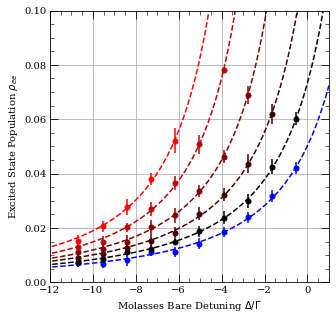

In [405]:
# Approach Curve Figure:
from scipy.optimize import curve_fit

def spectral_func(f, f0, amp):
    return amp /  (f - f0)**2

camera_adu_conversion = 1 / 0.28  # ADU/e-
path_efficiency_estimate = 0.014  # 6% NA, 70% Mitutoyo, 50% Path, 60% Andor
tau = 500e-3
gamma = 6.07

conversion_factor = camera_adu_conversion * path_efficiency_estimate * tau * (gamma*1e6 / 2)


tweezer_num = 2
pzt_num = 0
odt_att_num = 0
loop_start = 100
loop_stop = loop_start + 30

fig = plt.figure(figsize=(5.0, 5.0))
ax = fig.add_subplot(1, 1, 1)
red_color = np.linspace(0, 1, num_odt_att)

brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                     odt_att=odt_att_num,
                                     loop=slice(loop_start, loop_stop)).mean(dim='loop')
sigma_brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).std(dim='loop')
brightness_data = brightness_data / conversion_factor
sigma_brightness_data = sigma_brightness_data / conversion_factor
freq_data = brightness_data.coords['mol_freq'] / (gamma)

mask = np.logical_and( ~(np.isnan(brightness_data) | np.isnan(sigma_brightness_data) ), sigma_brightness_data !=0)

fit_dict = e6_fit(fit_func=spectral_func, input_data=freq_data[mask], output_data=brightness_data[mask], 
                  param_guess=[3, 1], param_keys=['f0', 'amp'])
print(fit_dict['kwargs'])
ref_f0 = fit_dict['f0']['val']
sigma_ref_f0 = fit_dict['f0']['std']
model_freq = np.linspace(-13, 1, 100)
model_brightness = spectral_func(model_freq, **fit_dict['kwargs'])

color = (red_color[odt_att_num], 0, 0)
ax.errorbar(freq_data, brightness_data,\
            yerr = sigma_brightness_data, linestyle='none', marker='.', markersize=10, color=(0, 0, 1))
ax.plot(model_freq, model_brightness, color=(0, 0, 1), linestyle='--')
f0_list = []
sigma_f0_list = []
for odt_att_num in range(num_odt_att):
    print(odt_att_num)
    brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).mean(dim='loop')
    sigma_brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).std(dim='loop')
    brightness_data = brightness_data / conversion_factor
    sigma_brightness_data = sigma_brightness_data / conversion_factor
    freq_data = brightness_data.coords['mol_freq'] / (gamma)
    
    mask = ~(np.isnan(brightness_data) | np.isnan(sigma_brightness_data))
    
    fit_dict = e6_fit(fit_func=spectral_func, input_data=freq_data[mask], output_data=brightness_data[mask], 
                      param_guess=[3, 1], param_keys=['f0', 'amp'])
#     print(fit_dict['kwargs'])
    f0val = fit_dict['f0']['val']
    f0std = fit_dict['f0']['std']
    print(f'{f0val} $\\pm$ {f0std}')
    model_freq = np.linspace(-13, 1, 100)
    model_brightness = spectral_func(model_freq, **fit_dict['kwargs'])
    f0_list.append(fit_dict['f0']['val'] - ref_f0)
    sigma_f0_list.append(np.sqrt(fit_dict['f0']['std']**2 + sigma_ref_f0**2))
    
    color = (red_color[odt_att_num], 0, 0)
    ax.errorbar(freq_data, brightness_data,\
                yerr = sigma_brightness_data, linestyle='none', marker='.', markersize=10, color=color)
    ax.plot(model_freq, model_brightness, color=color, linestyle='--')
ax.set_xlim(-12, 1)
ax.set_ylim(0, 0.1)
ax.set_xlabel(r'Molasses Bare Detuning $\Delta/\Gamma$')
ax.set_ylabel('Excited State Population $\\rho_{ee}$')
ax.grid(True)
plt.show()        
save_dir = Path(fig_directory)
save_dir.mkdir(parents=True, exist_ok=True)
file_name = f'figure -- pzt_num - {pzt_num} -- tweezer_num - {tweezer_num} -- approach_curve.png'
file_path = Path(save_dir, file_name)
fig.savefig(file_path, dpi=500)
plt.close(fig)



[   5.99413397 2742.70679339]
0
[   5.12913286 2921.38383495]
1
[   3.91149571 2945.02202009]
2
[2.35774595e+00 2.75999238e+03]
3
[6.45648775e-01 2.51959895e+03]


c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


4
[-6.7009631e-01  2.4697094e+03]


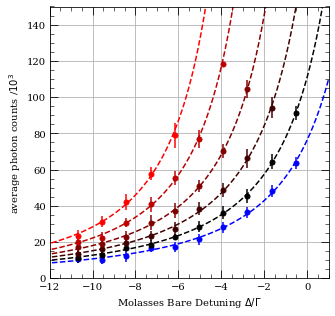

MemoryError: In RendererAgg: Out of memory

In [414]:
# Approach Curve Figure:
from scipy.optimize import curve_fit

def spectral_func(f, f0, amp):
    return amp /  (f - f0)**2

camera_adu_conversion = 1000 / 0.28  # ADU/e-
path_efficiency_estimate = 0.014  # 6% NA, 70% Mitutoyo, 50% Path, 60% Andor
# tau = 500e-3
# gamma = 6.07

# conversion_factor = camera_adu_conversion * path_efficiency_estimate * tau * (gamma*1e6 / 2)
conversion_factor = camera_adu_conversion * path_efficiency_estimate 


tweezer_num = 2
pzt_num = 0
odt_att_num = 0
loop_start = 100
loop_stop = loop_start + 30

fig = plt.figure(figsize=(5.0, 5.0))
ax = fig.add_subplot(1, 1, 1)
red_color = np.linspace(0, 1, num_odt_att)

brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                     odt_att=odt_att_num,
                                     loop=slice(loop_start, loop_stop)).mean(dim='loop')
sigma_brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).std(dim='loop')
brightness_data = brightness_data / conversion_factor
sigma_brightness_data = sigma_brightness_data / conversion_factor
freq_data = brightness_data.coords['mol_freq'] / (gamma)


mask = np.logical_and( ~(np.isnan(brightness_data) | np.isnan(sigma_brightness_data) ), sigma_brightness_data !=0)
    
popt, pcov = curve_fit(spectral_func, freq_data[mask], brightness_data[mask],\
                               sigma = sigma_brightness_data[mask], p0=[3,2500], maxfev = 10000)
ref_f0, ref_amp = popt
print(popt)
sigma_ref_amp = np.sqrt(pcov[1,1])
sigma_ref_f0 = np.sqrt(pcov[0,0])
model_freq = np.linspace(-13, 1, 100)
model_brightness = spectral_func(model_freq, ref_f0, ref_amp)

color = (red_color[odt_att_num], 0, 0)
ax.errorbar(freq_data, brightness_data,\
            yerr = sigma_brightness_data, linestyle='none', marker='.', markersize=10, color=(0, 0, 1))
ax.plot(model_freq, model_brightness, color=(0, 0, 1), linestyle='--')
stark_list = []
sigma_stark_list = []
for odt_att_num in range(num_odt_att):
    print(odt_att_num)
    brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).mean(dim='loop')
    sigma_brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).std(dim='loop')
    brightness_data = brightness_data / conversion_factor
    sigma_brightness_data = sigma_brightness_data / conversion_factor
    freq_data = brightness_data.coords['mol_freq'] / (gamma)
    

    mask = np.logical_and( ~(np.isnan(brightness_data) | np.isnan(sigma_brightness_data) ), sigma_brightness_data !=0)
    
    popt, pcov = curve_fit(spectral_func, freq_data[mask], brightness_data[mask],\
                                   sigma = sigma_brightness_data[mask],\
                           p0=[3,2500], maxfev = 100000)
    f0, amp = popt
    sigma_amp = np.sqrt(pcov[1,1])
    sigma_f0 = np.sqrt(pcov[0,0])
    print(popt)
#     print(f'{f0} $\\pm$ {sigma_f0}')
    
    model_freq = np.linspace(-13, 1, 100)
    model_brightness = spectral_func(model_freq, f0, amp)
    stark_list.append(f0 - ref_f0)
    sigma_stark_list.append(np.sqrt(sigma_f0**2 + sigma_ref_f0**2))
    
    color = (red_color[odt_att_num], 0, 0)
    ax.errorbar(freq_data, brightness_data,\
                yerr = sigma_brightness_data, linestyle='none', marker='.', markersize=10, color=color)
    ax.plot(model_freq, model_brightness, color=color, linestyle='--')
ax.set_xlim(-12, 1)
ax.set_ylim(0, 150)
ax.set_xlabel(r'Molasses Bare Detuning $\Delta/\Gamma$')
ax.set_ylabel('Average Photon Counts /$10^3$')
ax.grid(True)
plt.show()        
save_dir = Path(fig_directory)
save_dir.mkdir(parents=True, exist_ok=True)
file_name = f'figure -- pzt_num - {pzt_num} -- tweezer_num - {tweezer_num} -- approach_curve.png'
file_path = Path(save_dir, file_name)
fig.savefig(file_path, dpi=500)
plt.close(fig)



0
5.1291328589355345 $\pm$ 0.08626304387050947
1
3.911495707536123 $\pm$ 0.11612166915971367
2
2.3577459494344337 $\pm$ 0.08938752146540327
3
0.6456487751384071 $\pm$ 0.20779880234023435
4

c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)



-0.6700963096573217 $\pm$ 0.32320514641940007


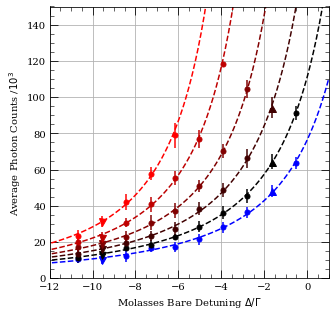

In [417]:
# Approach Curve Figure:
from scipy.optimize import curve_fit

def spectral_func(f, f0, amp):
    return amp /  (f - f0)**2

camera_adu_conversion = 1000 / 0.28  # ADU/e-
path_efficiency_estimate = 0.014  # 6% NA, 70% Mitutoyo, 50% Path, 60% Andor
tau = 500e-3
gamma = 6.07

conversion_factor = camera_adu_conversion * path_efficiency_estimate 


tweezer_num = 2
pzt_num = 0
odt_att_num = 0
loop_start = 100
loop_stop = loop_start + 30

fig = plt.figure(figsize=(5.0, 5.0))
ax = fig.add_subplot(1, 1, 1)
red_color = np.linspace(0, 1, num_odt_att)

brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                     odt_att=odt_att_num,
                                     loop=slice(loop_start, loop_stop)).mean(dim='loop')
sigma_brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).std(dim='loop')
brightness_data = brightness_data / conversion_factor
sigma_brightness_data = sigma_brightness_data / conversion_factor
freq_data = brightness_data.coords['mol_freq'] / (gamma)


mask = np.logical_and( ~(np.isnan(brightness_data) | np.isnan(sigma_brightness_data) ), sigma_brightness_data !=0)
    
popt, pcov = curve_fit(spectral_func, freq_data[mask], brightness_data[mask],\
                               sigma = sigma_brightness_data[mask], p0=[3,2500], maxfev = 10000)
ref_f0, ref_amp = popt
sigma_ref_amp = np.sqrt(pcov[1,1])
sigma_ref_f0 = np.sqrt(pcov[0,0])
model_freq = np.linspace(-13, 1, 100)
model_brightness = spectral_func(model_freq, ref_f0, ref_amp)

color = (red_color[odt_att_num], 0, 0)
other_freq = np.array([0,2,3,4,5,6,7,9])
ax.errorbar(freq_data[other_freq], brightness_data[other_freq],\
            yerr = sigma_brightness_data[other_freq], linestyle='none', marker='.', markersize=10, color=(0, 0, 1),label = '0')
ax.errorbar(freq_data[1], brightness_data[1],\
            yerr = sigma_brightness_data[1], linestyle='none', marker='v', markersize=7, color=(0, 0, 1))
ax.errorbar(freq_data[8], brightness_data[8],\
            yerr = sigma_brightness_data[8], linestyle='none', marker='^', markersize=7, color=(0, 0, 1))
ax.plot(model_freq, model_brightness, color=(0, 0, 1), linestyle='--')
stark_list = []
sigma_stark_list = []
for odt_att_num in range(num_odt_att):
    print(odt_att_num)
    brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).mean(dim='loop')
    sigma_brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).std(dim='loop')
    brightness_data = brightness_data / conversion_factor
    sigma_brightness_data = sigma_brightness_data / conversion_factor
    freq_data = brightness_data.coords['mol_freq'] / (gamma)
    

    mask = np.logical_and( ~(np.isnan(brightness_data) | np.isnan(sigma_brightness_data) ), sigma_brightness_data !=0)
    
    popt, pcov = curve_fit(spectral_func, freq_data[mask], brightness_data[mask],\
                                   sigma = sigma_brightness_data[mask],\
                           p0=[3,2500], maxfev = 100000)
    f0, amp = popt
    sigma_amp = np.sqrt(pcov[1,1])
    sigma_f0 = np.sqrt(pcov[0,0])
            
    print(f'{f0} $\\pm$ {sigma_f0}')
    
    model_freq = np.linspace(-13, 1, 100)
    model_brightness = spectral_func(model_freq, f0, amp)
    stark_list.append(f0 - ref_f0)
    sigma_stark_list.append(np.sqrt(sigma_f0**2 + sigma_ref_f0**2))
    
    color = (red_color[odt_att_num], 0, 0)
    ax.errorbar(freq_data[other_freq], brightness_data[other_freq],\
                yerr = sigma_brightness_data[other_freq], linestyle='none', marker='.', markersize=10, color=color,label=f'{odt_att_num+1}')
    ax.errorbar(freq_data[1], brightness_data[1],\
                yerr = sigma_brightness_data[1], linestyle='none', marker='v', markersize=7, color=color)
    ax.errorbar(freq_data[8], brightness_data[8],\
                yerr = sigma_brightness_data[8], linestyle='none', marker='^', markersize=7, color=color)
    ax.plot(model_freq, model_brightness, color=color, linestyle='--')
ax.set_xlim(-12, 1)
ax.set_ylim(0, 150)
ax.set_xlabel(r'Molasses Bare Detuning $\Delta/\Gamma$')
ax.set_ylabel('Average Photon Counts /$10^3$')
ax.grid(True)
# ax.legend(title='ODT intensity(AU)', bbox_to_anchor=(0, 1), loc='upper left',fancybox=True, framealpha=1)
# ax.legend(title='ODT intensity(AU)', bbox_to_anchor=(0, 1), loc='upper left',fancybox=True, framealpha=1, ncol = 6)
plt.show()        
save_dir = Path(fig_directory)
save_dir.mkdir(parents=True, exist_ok=True)
file_name = f'figure -- pzt_num - {pzt_num} -- tweezer_num - {tweezer_num} -- approach_curve_2.png'
file_path = Path(save_dir, file_name)
fig.savefig(file_path, dpi=400)
plt.close(fig)



0
5.129132861544586 $\pm$ 0.08626305155171055
1
3.911495699413178 $\pm$ 0.11612168018595084
2
2.3577459465325803 $\pm$ 0.08938751830553641
3
0.6456490679335865 $\pm$ 0.20779806618171595


c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


4
-0.6700971549006488 $\pm$ 0.3232068070720129


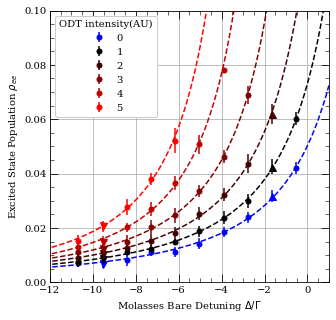

In [258]:
# Approach Curve Figure:
from scipy.optimize import curve_fit

def spectral_func(f, f0, amp):
    return amp /  (f - f0)**2

camera_adu_conversion = 1 / 0.28  # ADU/e-
path_efficiency_estimate = 0.014  # 6% NA, 70% Mitutoyo, 50% Path, 60% Andor
tau = 500e-3
gamma = 6.07

conversion_factor = camera_adu_conversion * path_efficiency_estimate * tau * (gamma*1e6 / 2)


tweezer_num = 2
pzt_num = 0
odt_att_num = 0
loop_start = 100
loop_stop = loop_start + 30

fig = plt.figure(figsize=(5.0, 5.0))
ax = fig.add_subplot(1, 1, 1)
red_color = np.linspace(0, 1, num_odt_att)

brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                     odt_att=odt_att_num,
                                     loop=slice(loop_start, loop_stop)).mean(dim='loop')
sigma_brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).std(dim='loop')
brightness_data = brightness_data / conversion_factor
sigma_brightness_data = sigma_brightness_data / conversion_factor
freq_data = brightness_data.coords['mol_freq'] / (gamma)


mask = np.logical_and( ~(np.isnan(brightness_data) | np.isnan(sigma_brightness_data) ), sigma_brightness_data !=0)
    
popt, pcov = curve_fit(spectral_func, freq_data[mask], brightness_data[mask],\
                               sigma = sigma_brightness_data[mask], p0=[3,1], maxfev = 10000)
ref_f0, ref_amp = popt
sigma_ref_amp = np.sqrt(pcov[1,1])
sigma_ref_f0 = np.sqrt(pcov[0,0])
model_freq = np.linspace(-13, 1, 100)
model_brightness = spectral_func(model_freq, ref_f0, ref_amp)

color = (red_color[odt_att_num], 0, 0)
other_freq = np.array([0,2,3,4,5,6,7,9])
ax.errorbar(freq_data[other_freq], brightness_data[other_freq],\
            yerr = sigma_brightness_data[other_freq], linestyle='none', marker='.', markersize=10, color=(0, 0, 1),label = '0')
ax.errorbar(freq_data[1], brightness_data[1],\
            yerr = sigma_brightness_data[1], linestyle='none', marker='v', markersize=7, color=(0, 0, 1))
ax.errorbar(freq_data[8], brightness_data[8],\
            yerr = sigma_brightness_data[8], linestyle='none', marker='^', markersize=7, color=(0, 0, 1))
ax.plot(model_freq, model_brightness, color=(0, 0, 1), linestyle='--')
stark_list = []
sigma_stark_list = []
for odt_att_num in range(num_odt_att):
    print(odt_att_num)
    brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).mean(dim='loop')
    sigma_brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).std(dim='loop')
    brightness_data = brightness_data / conversion_factor
    sigma_brightness_data = sigma_brightness_data / conversion_factor
    freq_data = brightness_data.coords['mol_freq'] / (gamma)
    

    mask = np.logical_and( ~(np.isnan(brightness_data) | np.isnan(sigma_brightness_data) ), sigma_brightness_data !=0)
    
    popt, pcov = curve_fit(spectral_func, freq_data[mask], brightness_data[mask],\
                                   sigma = sigma_brightness_data[mask],\
                           p0=[3,1], maxfev = 100000)
    f0, amp = popt
    sigma_amp = np.sqrt(pcov[1,1])
    sigma_f0 = np.sqrt(pcov[0,0])
            
    print(f'{f0} $\\pm$ {sigma_f0}')
    
    model_freq = np.linspace(-13, 1, 100)
    model_brightness = spectral_func(model_freq, f0, amp)
    stark_list.append(f0 - ref_f0)
    sigma_stark_list.append(np.sqrt(sigma_f0**2 + sigma_ref_f0**2))
    
    color = (red_color[odt_att_num], 0, 0)
    ax.errorbar(freq_data[other_freq], brightness_data[other_freq],\
                yerr = sigma_brightness_data[other_freq], linestyle='none', marker='.', markersize=10, color=color,label=f'{odt_att_num+1}')
    ax.errorbar(freq_data[1], brightness_data[1],\
                yerr = sigma_brightness_data[1], linestyle='none', marker='v', markersize=7, color=color)
    ax.errorbar(freq_data[8], brightness_data[8],\
                yerr = sigma_brightness_data[8], linestyle='none', marker='^', markersize=7, color=color)
    ax.plot(model_freq, model_brightness, color=color, linestyle='--')
ax.set_xlim(-12, 1)
ax.set_ylim(0, 0.1)
ax.set_xlabel(r'Molasses Bare Detuning $\Delta/\Gamma$')
ax.set_ylabel('Excited State Population $\\rho_{ee}$')
ax.grid(True)
ax.legend(title='ODT intensity(AU)', bbox_to_anchor=(0, 1), loc='upper left',fancybox=True, framealpha=1)
# ax.legend(title='ODT intensity(AU)', bbox_to_anchor=(0, 1), loc='upper left',fancybox=True, framealpha=1, ncol = 6)
plt.show()        
save_dir = Path(fig_directory)
save_dir.mkdir(parents=True, exist_ok=True)
file_name = f'figure -- pzt_num - {pzt_num} -- tweezer_num - {tweezer_num} -- approach_curve_2.png'
file_path = Path(save_dir, file_name)
fig.savefig(file_path, dpi=400)
plt.close(fig)



In [172]:

brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                     loop=slice(loop_start, loop_stop)).mean(dim='loop')
sigma_brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                     loop=slice(loop_start, loop_stop)).std(dim='loop')
brightness_data = brightness_data / conversion_factor
sigma_brightness_data = sigma_brightness_data / conversion_factor
freq_data = brightness_data.coords['mol_freq'] / gamma

stark_xarray =  freq_data - bright_to_det(brightness_data,ref_f0,ref_amp)
sigma_stark_xarray = root_sum_square(sigma_ref_f0,\
                               sigma_ref_amp/(2*np.sqrt(ref_amp*brightness_data)),\
                               sigma_brightness_data/2*np.sqrt(ref_amp/brightness_data**3))

print(f0_xarray)
print(sigma_f0_xarray)

<xarray.DataArray (mol_freq: 10, odt_att: 5)>
array([[-1.12756907, -2.42579808, -3.99346879, -4.9431217 , -5.81016113],
       [-1.00797978, -2.44111561, -3.41816344, -4.49044893, -6.16337031],
       [-1.64427044, -2.50138413, -3.43002044, -4.97418532, -6.33516689],
       [-1.07894312, -2.44265688, -3.83449489, -5.0904265 , -6.39455851],
       [-1.14634514, -2.14451267, -3.59361995, -5.1191489 , -6.26759408],
       [-1.21178672, -2.56739033, -3.69055353, -5.06065923,         nan],
       [-1.19083596, -2.40765161, -3.64936934, -5.09137213,         nan],
       [-1.00980979, -2.34357764, -3.65147723,         nan,         nan],
       [-1.12292994, -2.24969282,         nan,         nan,         nan],
       [-1.03817358,         nan,         nan,         nan,         nan]])
Coordinates:
  * mol_freq  (mol_freq) float64 -64.8 -57.95 -51.11 ... -16.88 -10.04 -3.19
    tweezer   int32 112
    pzt       float64 5.5
  * odt_att   (odt_att) float64 0.2 0.4 0.6 0.8 1.0
<xarray.DataArray (mo

c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [175]:
stark_xarray[0]

<xarray.DataArray (odt_att: 5)>
array([-1.12756907, -2.42579808, -3.99346879, -4.9431217 , -5.81016113])
Coordinates:
    mol_freq  float64 -64.8
    tweezer   int32 112
    pzt       float64 5.5
  * odt_att   (odt_att) float64 0.2 0.4 0.6 0.8 1.0

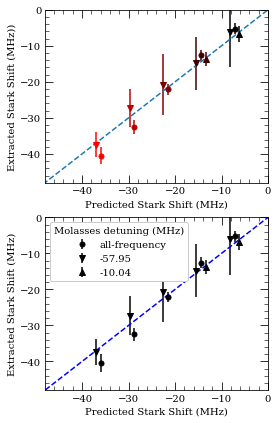

<Figure size 108x93.6 with 0 Axes>

In [252]:

from arc import Rubidium, DynamicPolarizability
from scipy.constants import c, epsilon_0
atom = Rubidium()
n_gnd = atom.groundStateN  # n=5
gnd_calc = DynamicPolarizability(atom, n_gnd, 0, 1/2)  # 5S_1/2 ground state
gnd_calc.defineBasis(atom.groundStateN, n_gnd + 4)

n_exc = atom.groundStateN
exc_calc = DynamicPolarizability(atom, n_exc, 1, 3/2)  # 5P_3/2 excited state
exc_calc.defineBasis(atom.groundStateN, n_exc + 5)

wavelength = 1560e-9
alpha0, alpha1, alpha2, alphaC, alphaP, closestState = exc_calc.getPolarizability(wavelength, units="SI")

def cicero_volt_to_power_out(voltage):
    return 6.6e-6 * 10 / 3.92 * voltage  # output power in W

power = cicero_volt_to_power_out(np.array(odt_att_list))
t2 = np.sqrt(100e-6)
w0 = 24e-6
E_field = (4 / w0) * (1 / t2) * np.sqrt(power / (np.pi * epsilon_0 * c)) 

shift = 1 / 4 * alpha0 * (E_field)**2 * 1e-6  # Stark shift in MHz
shift_fudged = 1 / 4 * alpha0 * (E_field)**2 * 1e-6 * 0.55  # Stark shift in MHz
# print(shift/gamma)
fig2 = plt.figure(figsize=(4.0, 7))
ax1 = fig2.add_subplot(2, 1,  1)
# ax2.plot(np.array(f0_list) * gamma, -shift, '.')
for odt_att_num in range(num_odt_att):
    ax1.errorbar(-shift_fudged[odt_att_num], stark_list[odt_att_num] * gamma, \
             yerr = sigma_stark_list[odt_att_num] * gamma, marker = '.', ls = 'none', color = (red_color[odt_att_num], 0, 0),ms = 10)

mol_freq_select = [1, 8]
markerlist = ['v','^']
dodgelist = [-1, 1]
for mol_freq_counter, mol_freq_num in enumerate(mol_freq_select):
    for odt_att_num in range(num_odt_att):
        ax1.errorbar(-shift_fudged[odt_att_num] + dodgelist[mol_freq_counter], stark_xarray[mol_freq_num, odt_att_num] * gamma, \
                 yerr = sigma_stark_xarray[mol_freq_num, odt_att_num] * gamma, ls = 'none', marker = markerlist[mol_freq_counter],\
                 color = (red_color[odt_att_num], 0, 0))
ax1.plot(np.linspace(-60, 0, 100), np.linspace(-60, 0, 100), '--')
ax1.set_xlim(-48, 0)
ax1.set_ylim(-48, 0)
ax1.set_ylabel('Extracted Stark Shift (MHz))')
ax1.set_xlabel('Predicted Stark Shift (MHz)')

ax2 = fig2.add_subplot(2, 1, 2)

ax2.errorbar(-shift_fudged, np.array(stark_list) * gamma, \
             yerr = np.array(sigma_stark_list) * gamma, marker = '.', ls = 'none', color = 'black',ms = 10, label = 'all-frequency')

for mol_freq_counter, mol_freq_num in enumerate(mol_freq_select):
    ax2.errorbar(-shift_fudged + dodgelist[mol_freq_counter], stark_xarray[mol_freq_num] * gamma, \
             yerr = sigma_stark_xarray[mol_freq_num] * gamma, ls = 'none', marker = markerlist[mol_freq_counter],\
             color = 'black', label = f'{mol_freq_list[mol_freq_num]:.2f}')
ax2.plot(np.linspace(-60, 0, 100), np.linspace(-60, 0, 100), '--',color='b')
ax2.set_xlim(-48, 0)
ax2.set_ylim(-48, 0)
ax2.set_ylabel(f'Extracted Stark Shift (MHz)')
ax2.set_xlabel('Predicted Stark Shift (MHz)')
ax2.legend(title='Molasses detuning (MHz)', bbox_to_anchor=(0, 1), loc='upper left',fancybox=True, framealpha=1)
figlegend = pylab.figure(figsize = (1.5,1.3))

# produce a legend for the objects in the other figure
pylab.figlegend(*ax2.get_legend_handles_labels(), loc = 'upper left')
plt.show()  
save_dir = Path(fig_directory)
save_dir.mkdir(parents=True, exist_ok=True)
file_name = f'figure -- pzt_num - {pzt_num} -- tweezer_num - {tweezer_num} -- single vs all.png'
file_path = Path(save_dir, file_name)
fig2.savefig(file_path, dpi=500,bbox_inches='tight', pad_inches = 0.5)
legend_name = f'figure -- pzt_num - {pzt_num} -- tweezer_num - {tweezer_num} -- single vs all -- legend.png'
legend_path = Path(save_dir, legend_name)
figlegend.savefig(legend_path, dpi=500)
plt.close(fig2)



{'f0': 35.68538769369277, 'amp': 4997077.425552836}


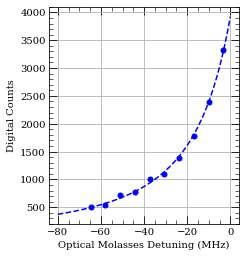

In [17]:
# Reference Inversion
def spectral_func(f, f0, amp):
    return amp /  (f - f0)**2

def inverse_spectral_func(brightness, amp):
    return -np.sqrt(amp / brightness)

def brightness_to_shift(brightness, amp, f_tweezer, f_molasses):
    detuning = inverse_spectral_func(brightness, amp)
    odt_shift = detuning  - f_molasses + 2 * f_tweezer
    return odt_shift


tweezer_num = 4
pzt_num = 0
loop_start = 100
loop_stop = loop_start + 30

fig = plt.figure(figsize=(3.4, 4.0))
ax = fig.add_subplot(1, 1, 1)
red_color = np.linspace(0, 1, num_odt_att)

brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                     odt_att=odt_att_num,
                                     loop=slice(loop_start, loop_stop)).mean(dim='loop')
brightness_data = brightness_data
freq_data = brightness_data.coords['mol_freq']

mask = np.logical_not(np.isnan(brightness_data))

fit_dict = e6_fit(fit_func=spectral_func, input_data=freq_data[mask], output_data=brightness_data[mask], 
                  param_guess=[30, 1000000], param_keys=['f0', 'amp'])
amp = fit_dict['amp']['val']
f_tweezer = fit_dict['f0']['val'] / 2
brightness_to_shift_cal = lambda brightness, f_molasses: brightness_to_shift(brightness, amp, f_tweezer, f_molasses)
print(fit_dict['kwargs'])
model_freq = np.linspace(-80, 0, 100)
model_brightness = spectral_func(model_freq, **fit_dict['kwargs'])

color = (red_color[odt_att_num], 0, 0)
ax.plot(freq_data, brightness_data, linestyle='none', marker='.', markersize=10, color=(0, 0, 1))
ax.plot(model_freq, model_brightness, color=(0, 0, 1), linestyle='--')
# ax.set_ylim(0, 1000)
ax.set_xlabel(r'Optical Molasses Detuning (MHz)')
ax.set_ylabel('Digital Counts')
ax.grid(True)

In [18]:
brightness_to_shift_cal(1500, -20)

-2.0327632674092087

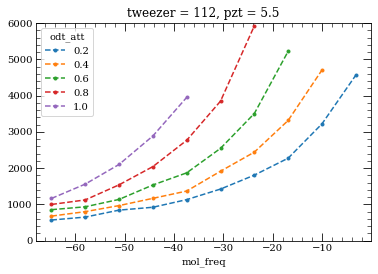

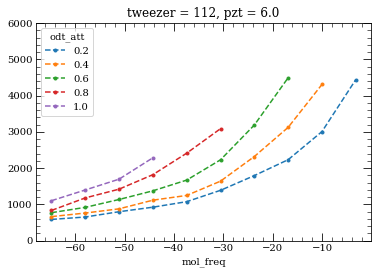

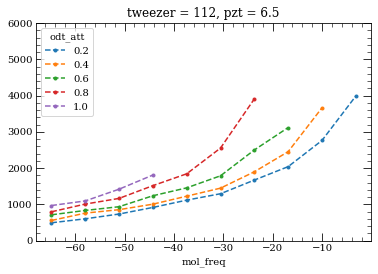

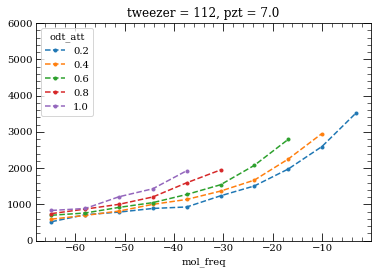

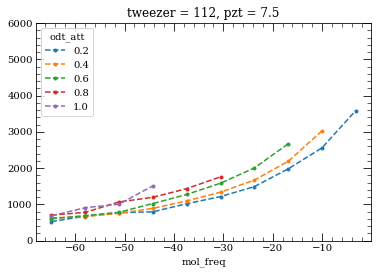

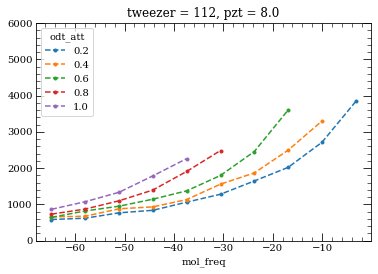

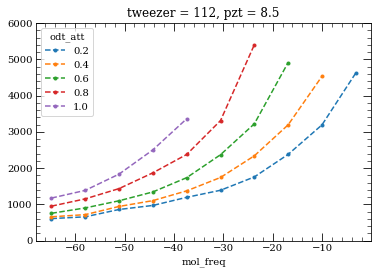

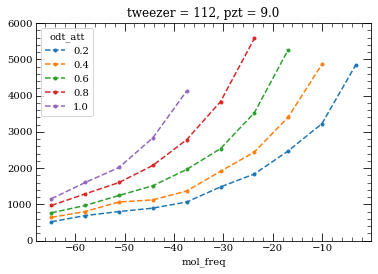

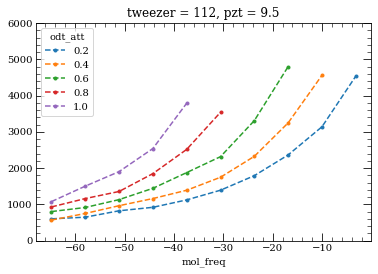

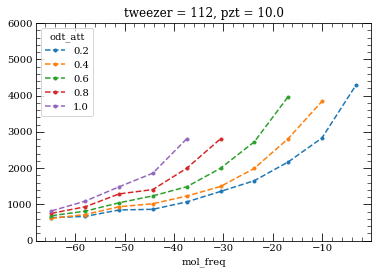

In [19]:
loop_start = 100
loop_stop = loop_start + 30
for pzt_num in range(num_pzt):
    brightness_xr.isel(tweezer=2, pzt=pzt_num, loop=slice(loop_start, loop_stop)).mean(dim='loop').plot.line(x='mol_freq', linestyle='--', marker='.')
    plt.ylim(0, 6000)
    plt.show()

c:\python37-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


tweezer_num=0


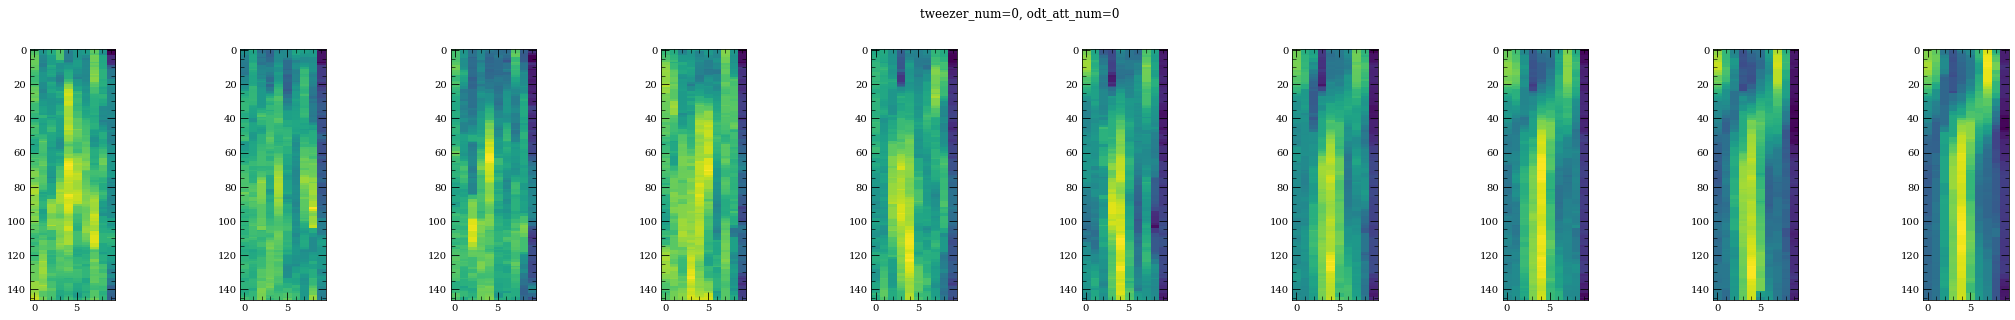

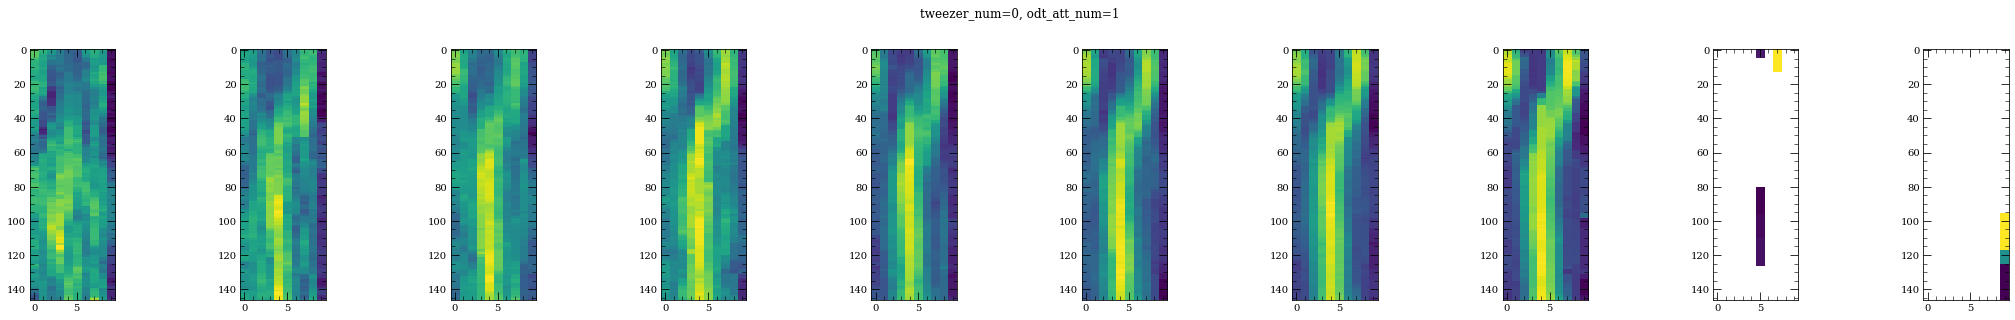

C:\Users\Microscope\AppData\Roaming\Python\Python37\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\Microscope\AppData\Roaming\Python\Python37\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\Microscope\AppData\Roaming\Python\Python37\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\Microscope\AppData\Roaming\Python\Python37\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
c:\python37-32\lib\site-packages\numpy\ma\core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


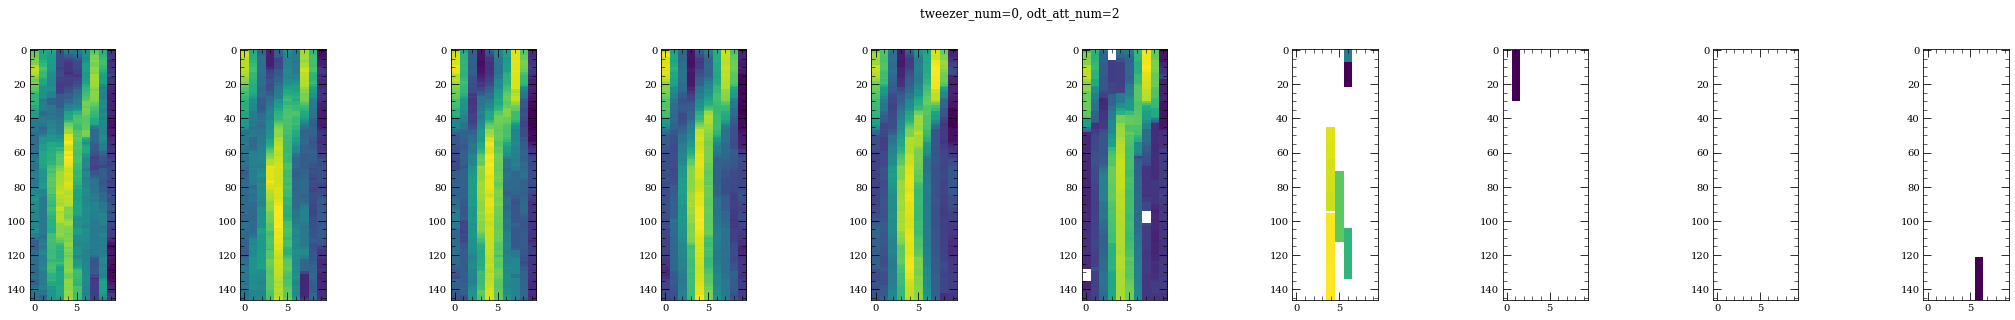

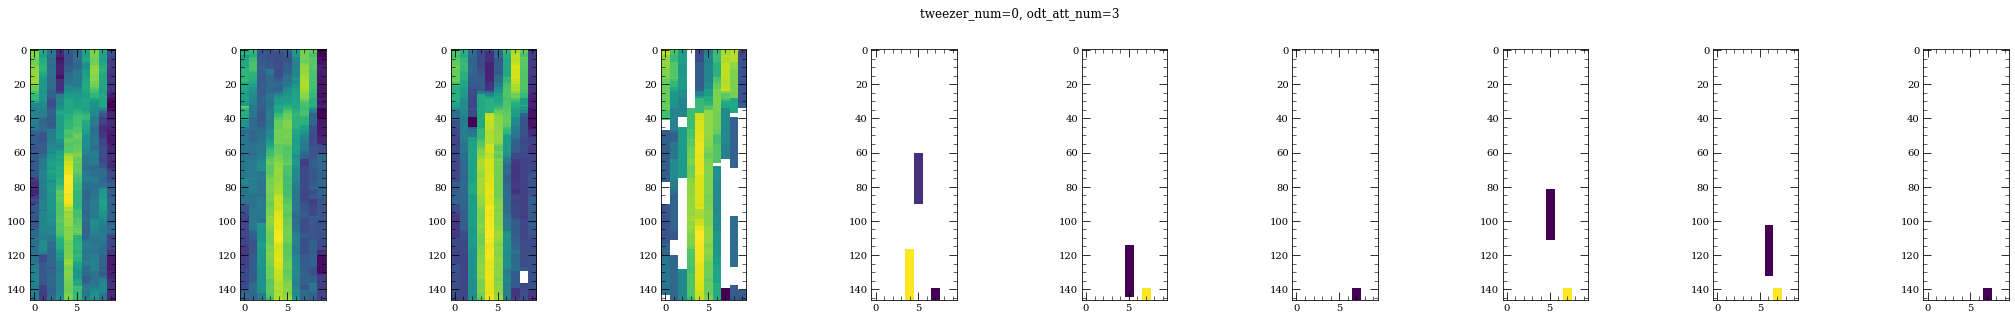

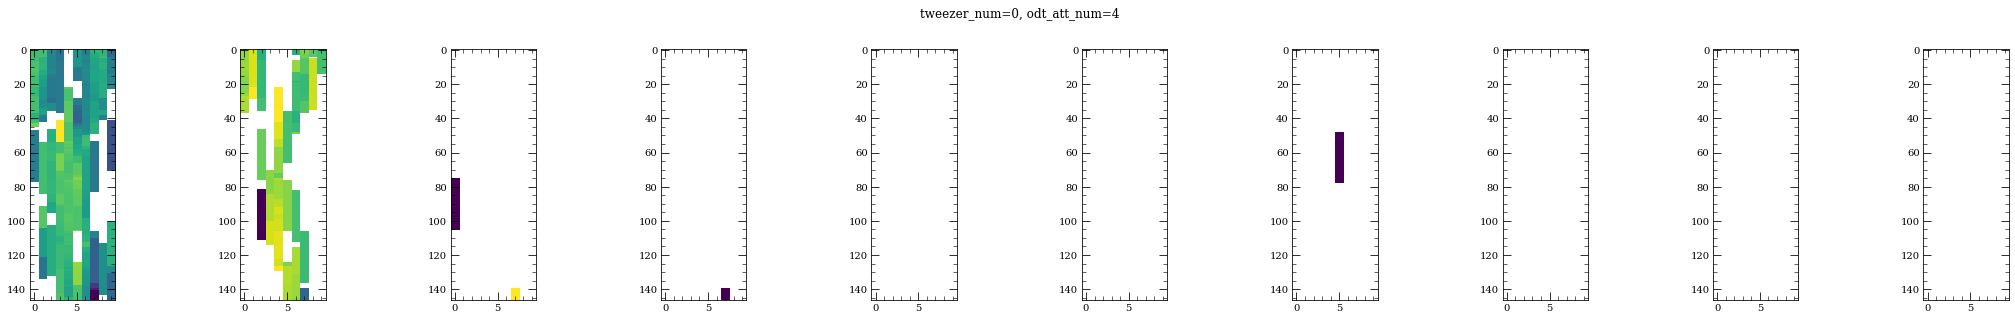

tweezer_num=1


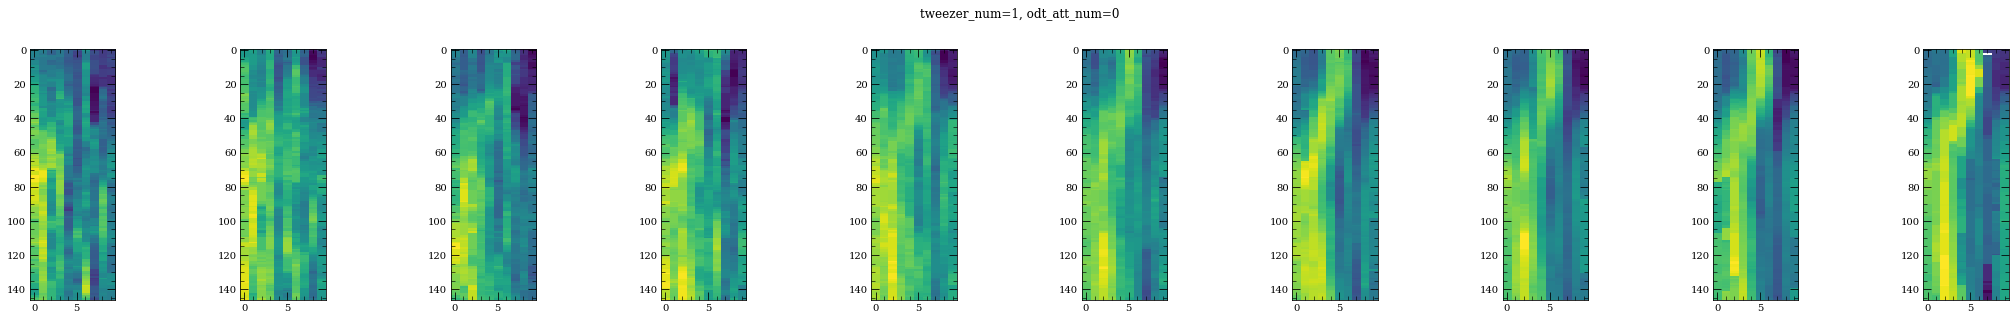

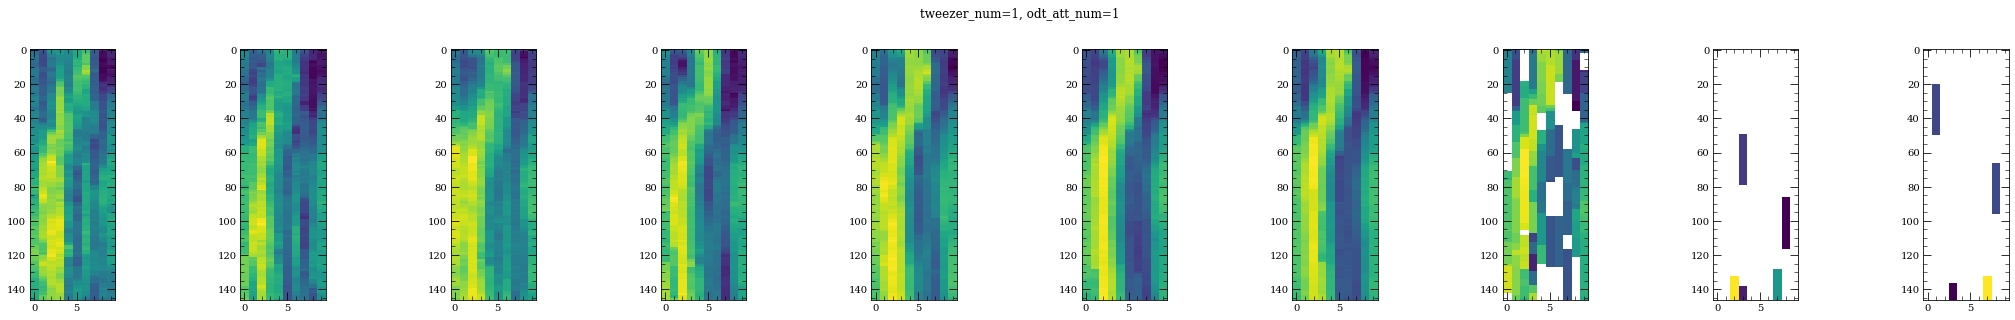

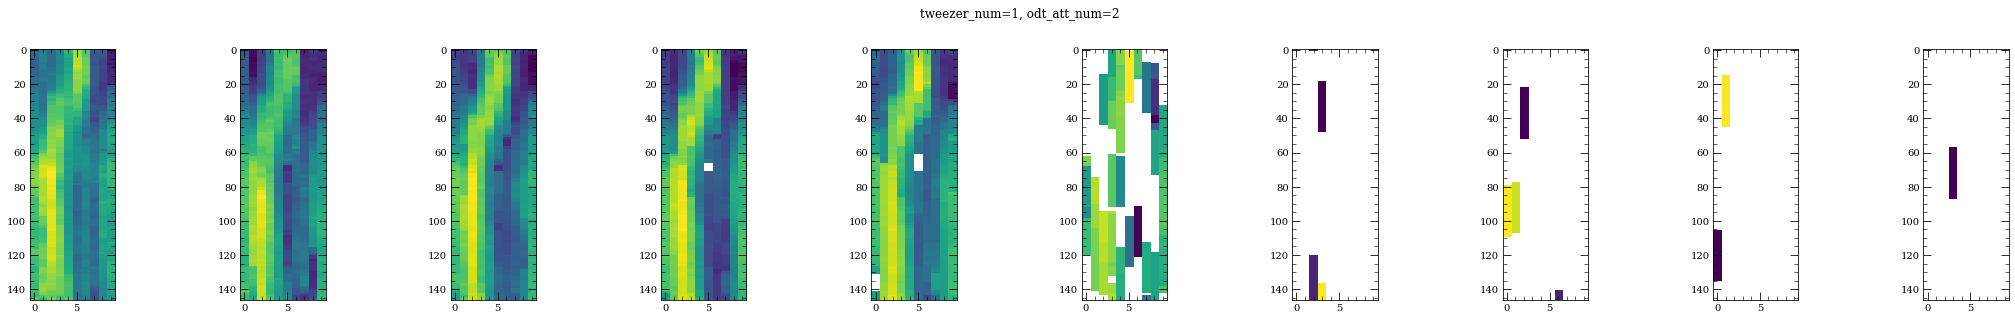

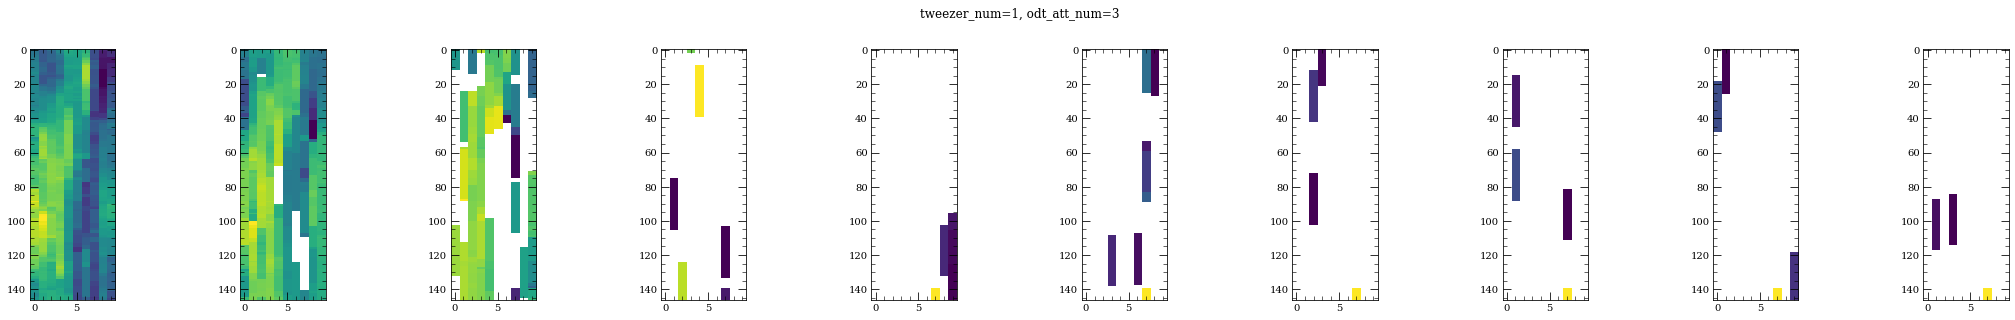

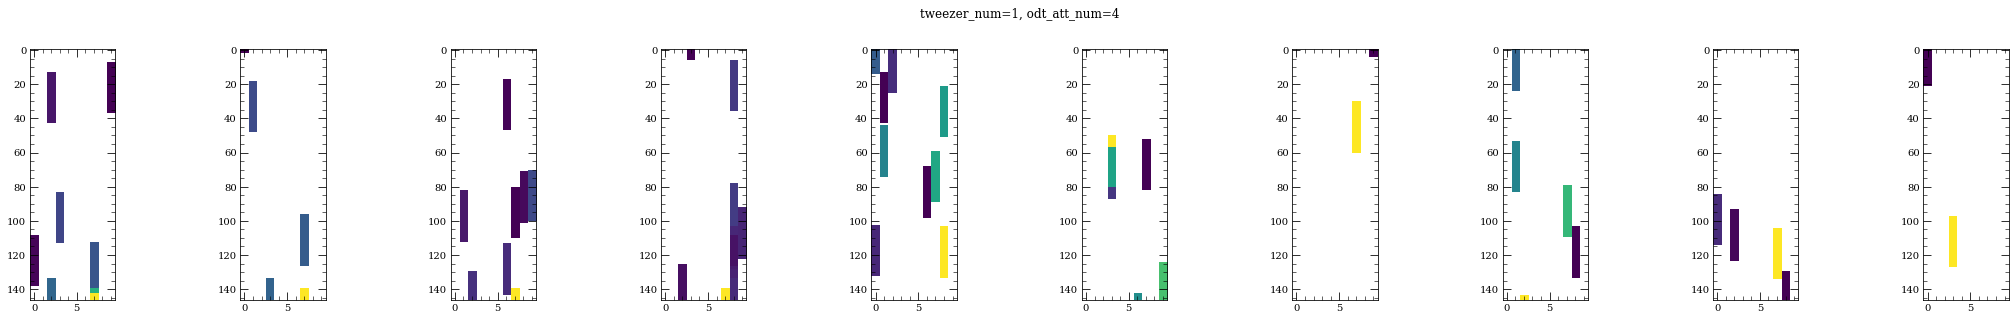

tweezer_num=2


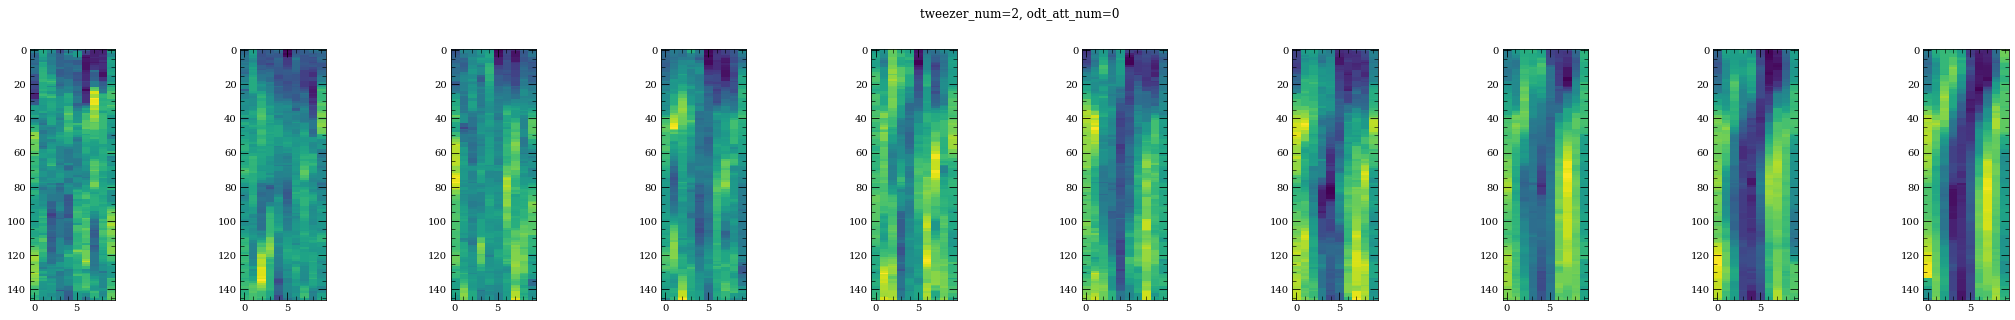

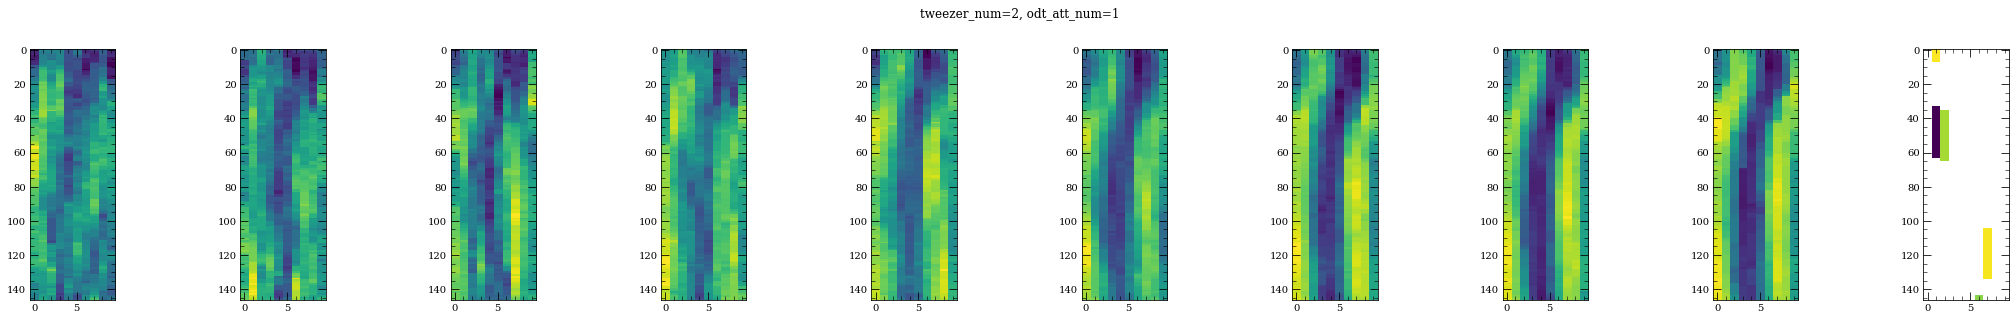

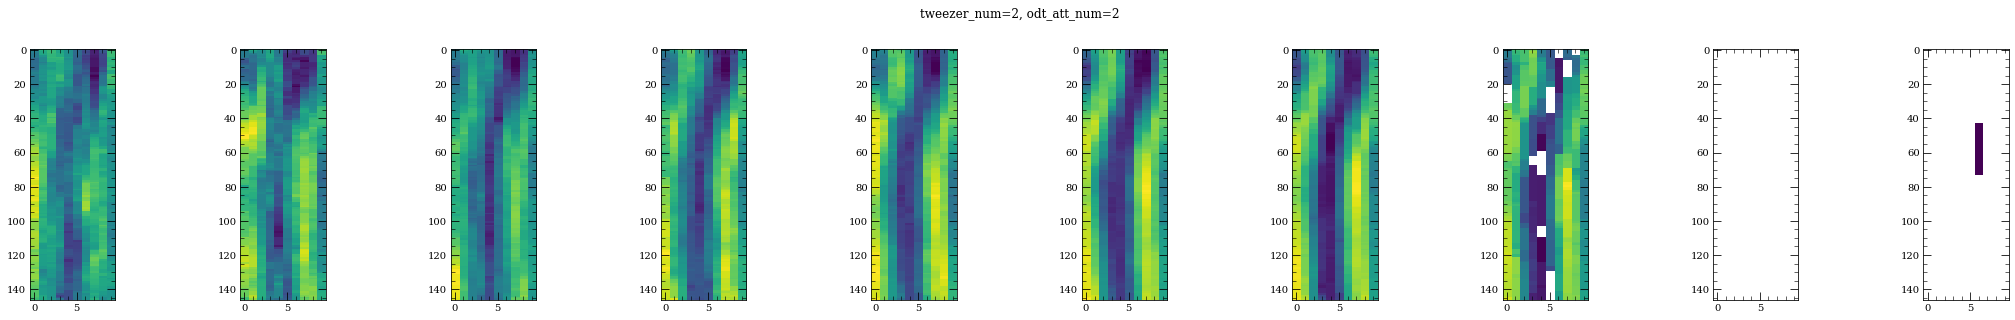

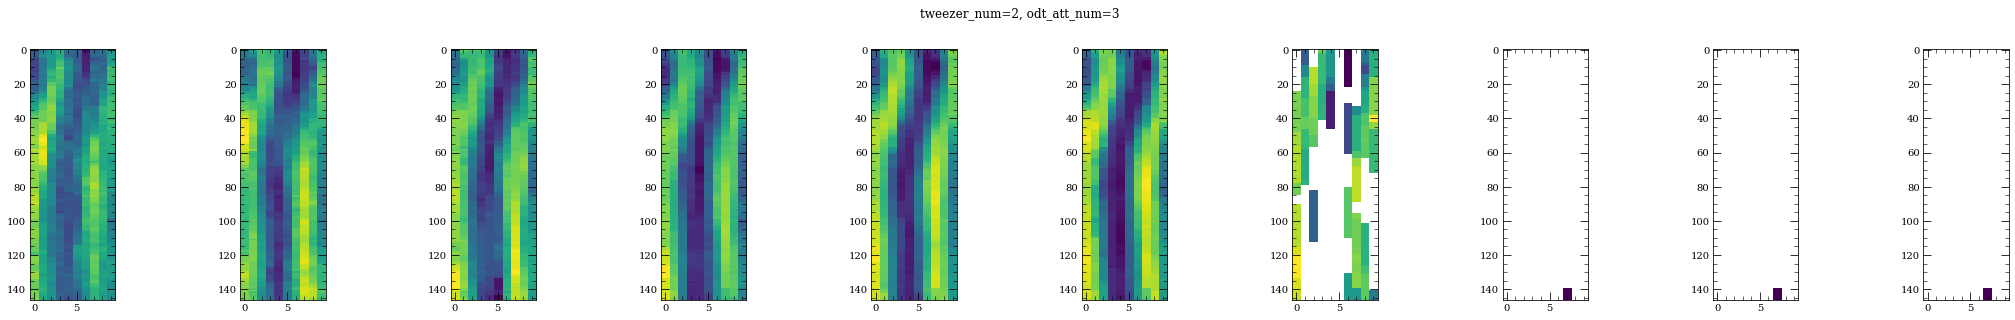

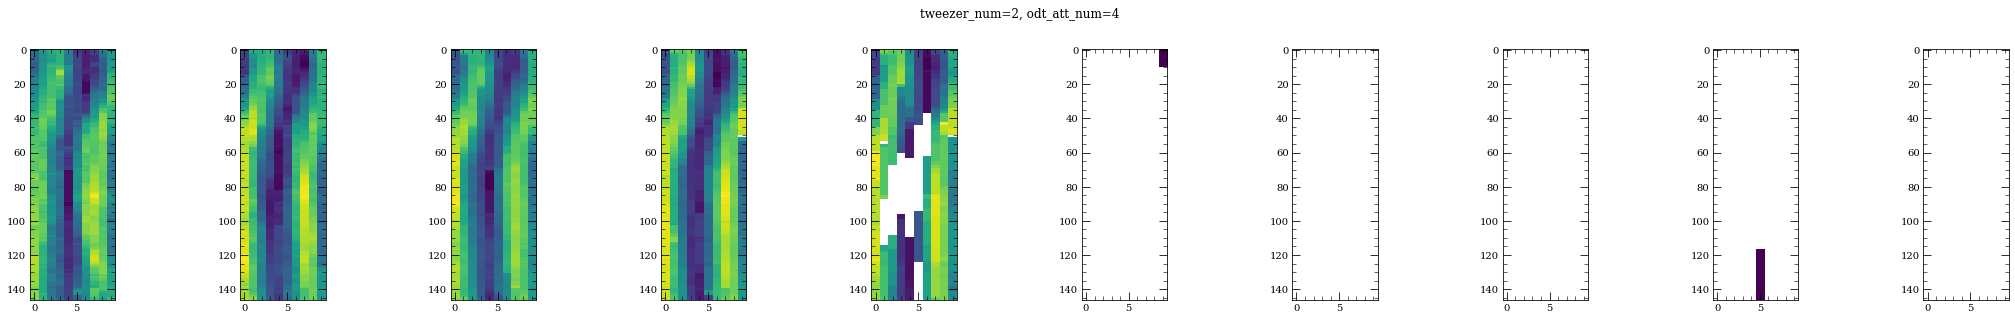

tweezer_num=3


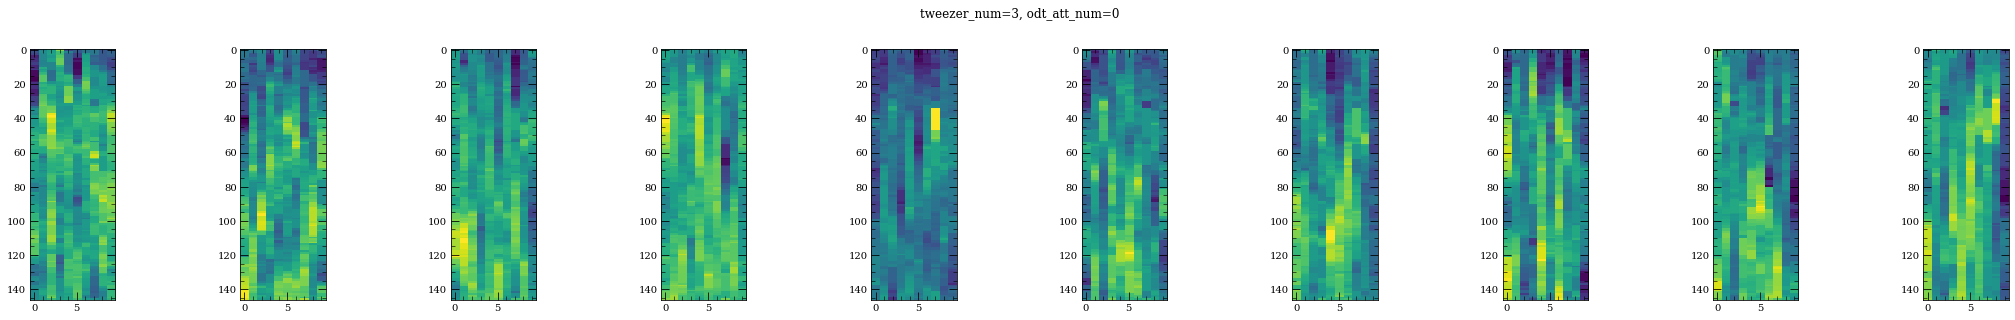

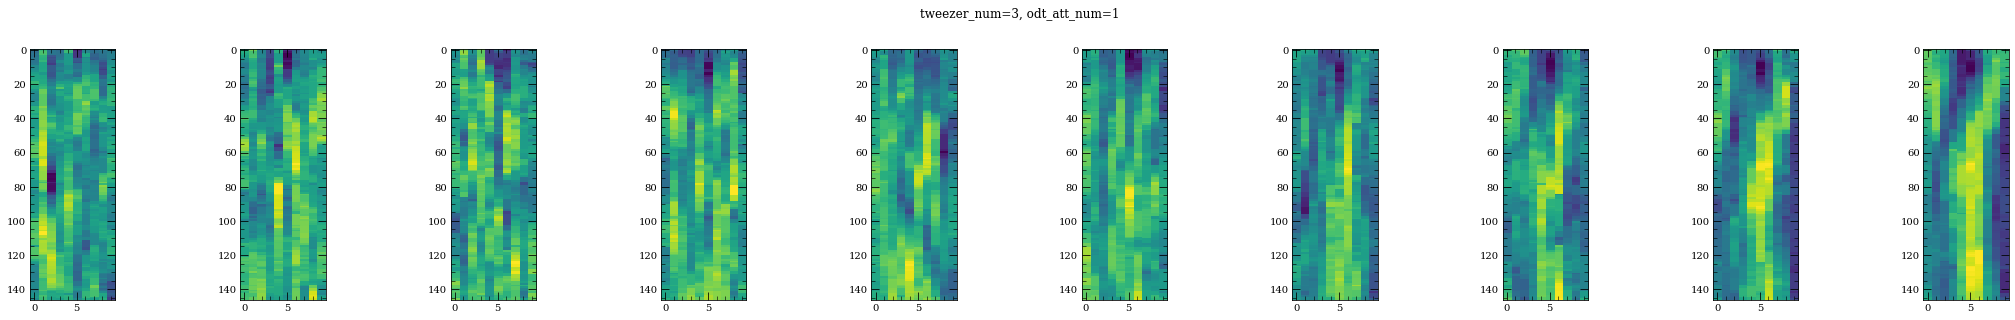

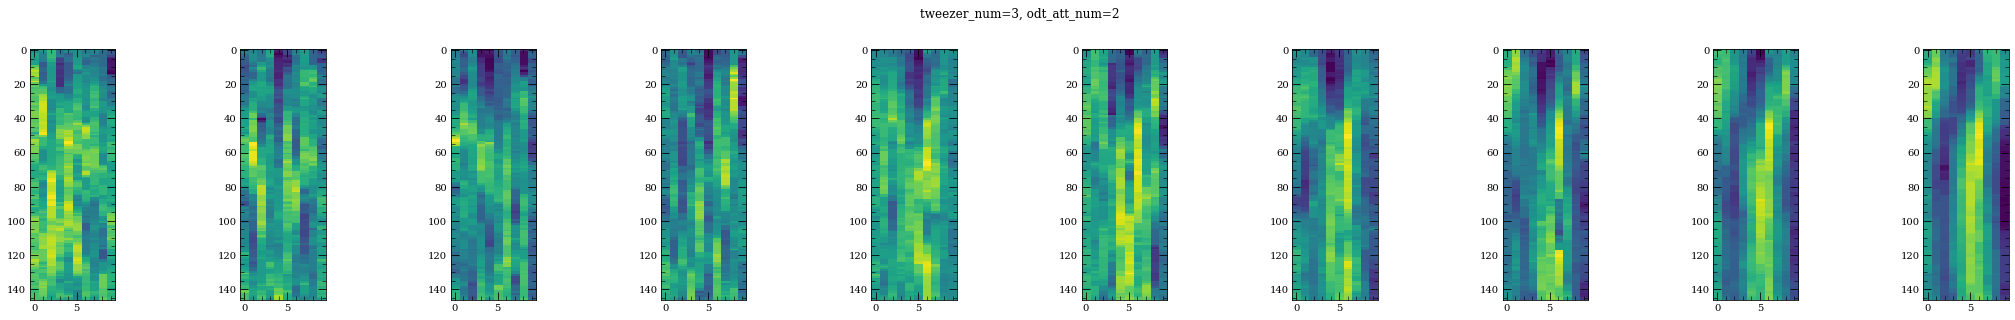

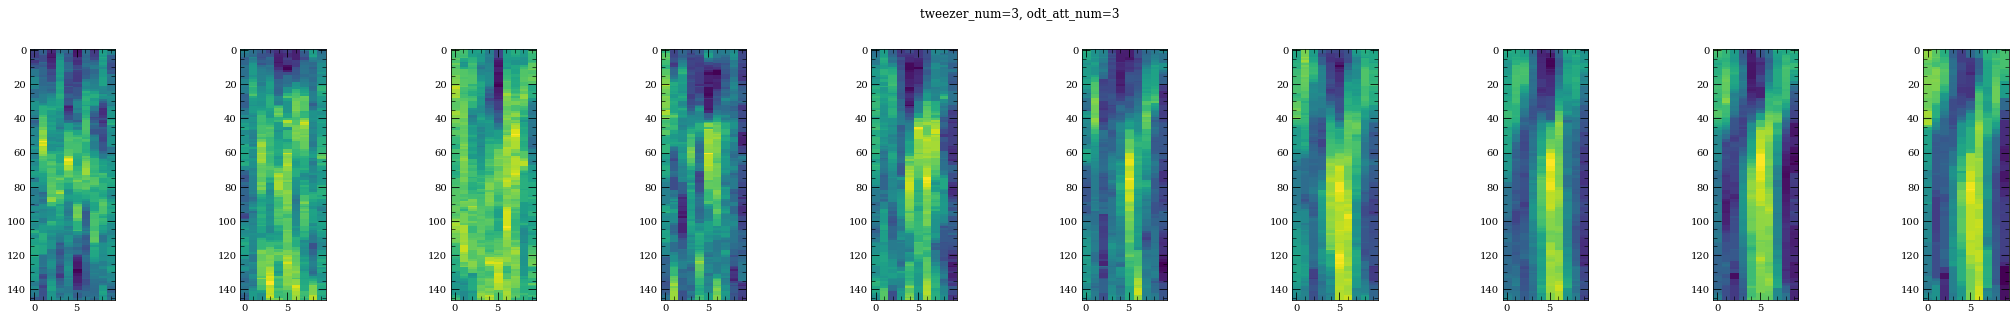

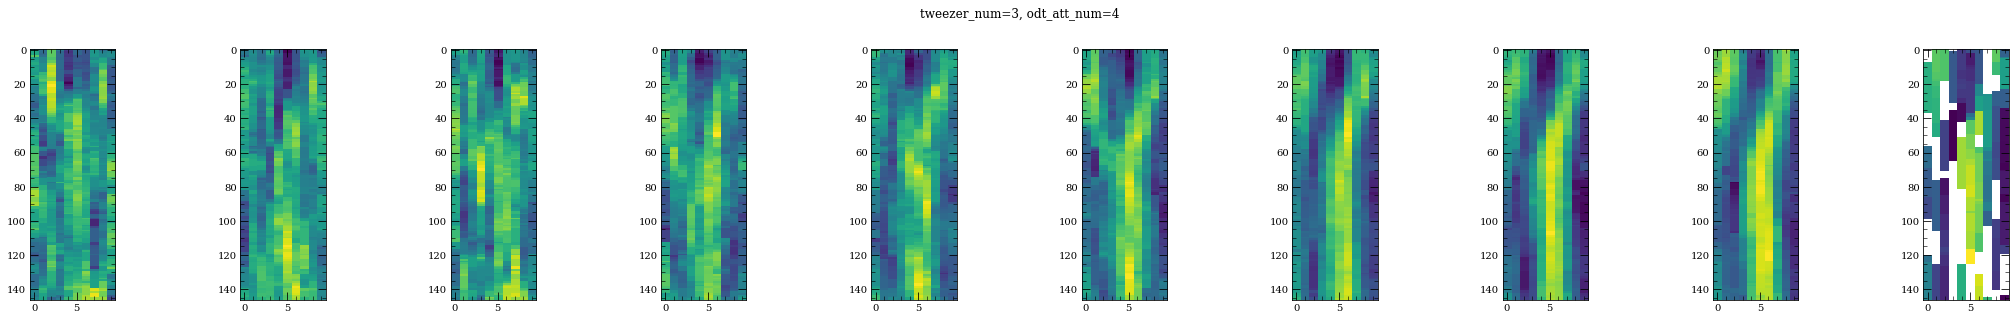

tweezer_num=4


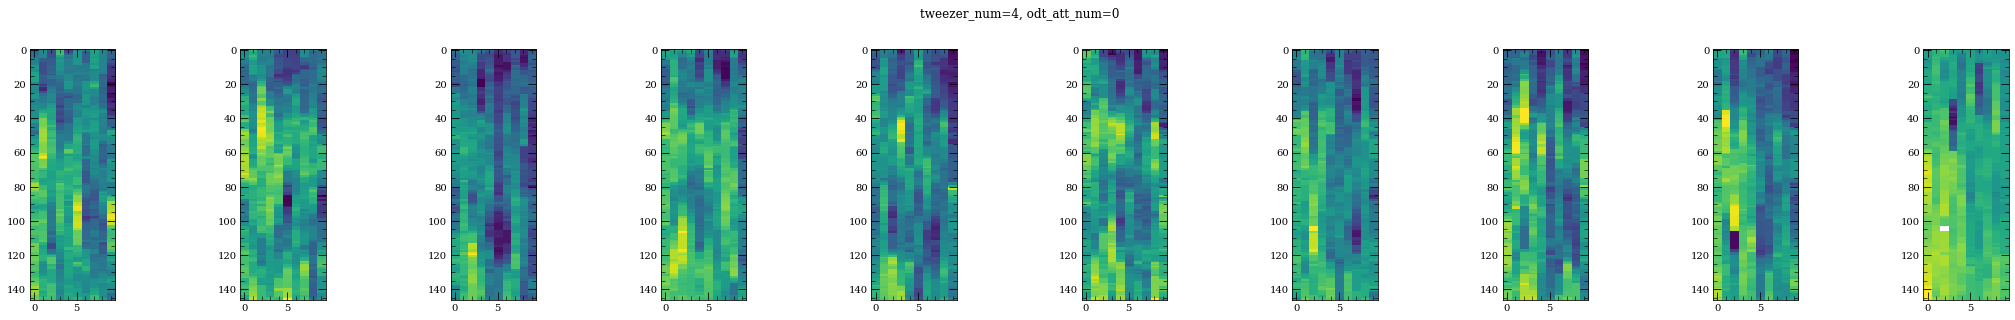

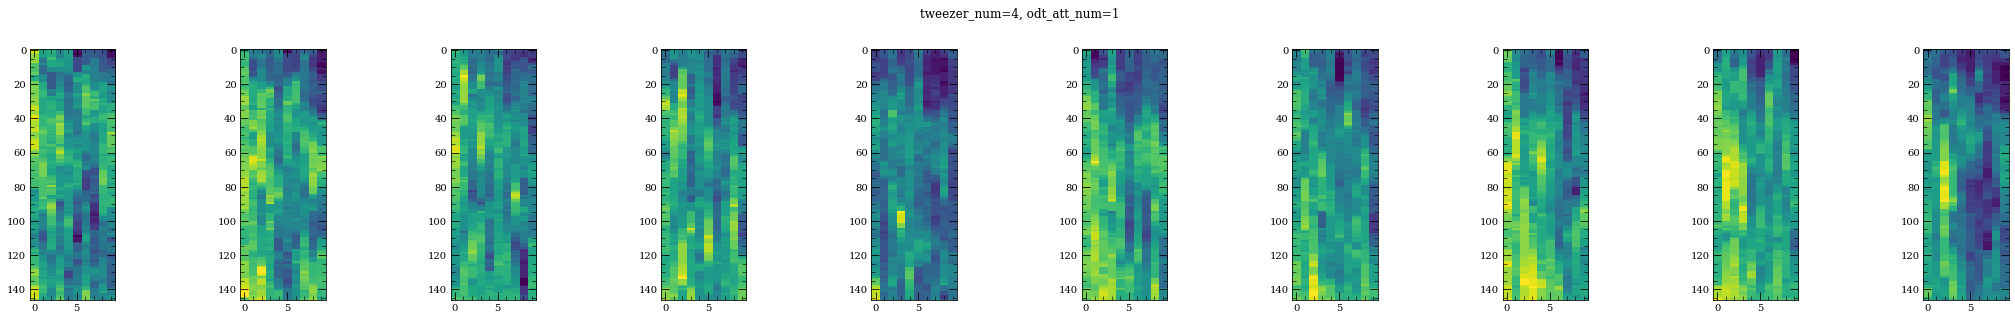

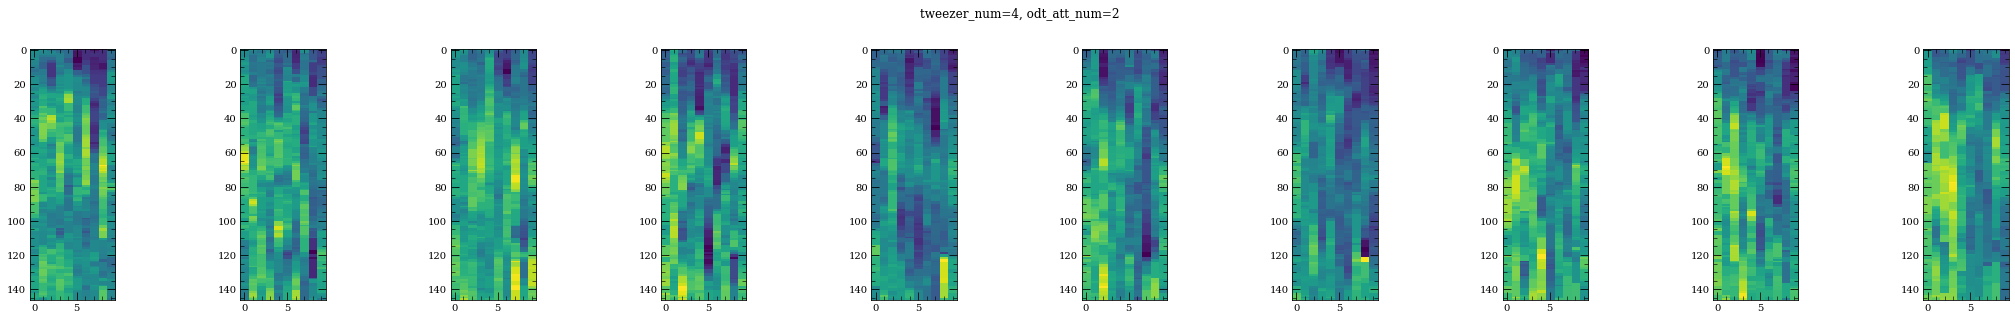

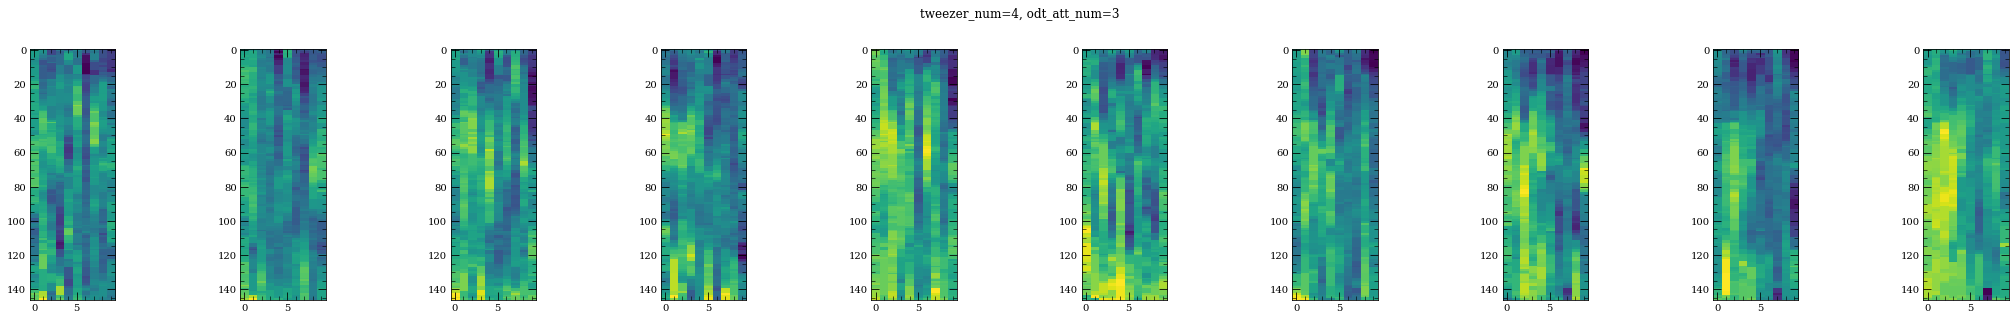

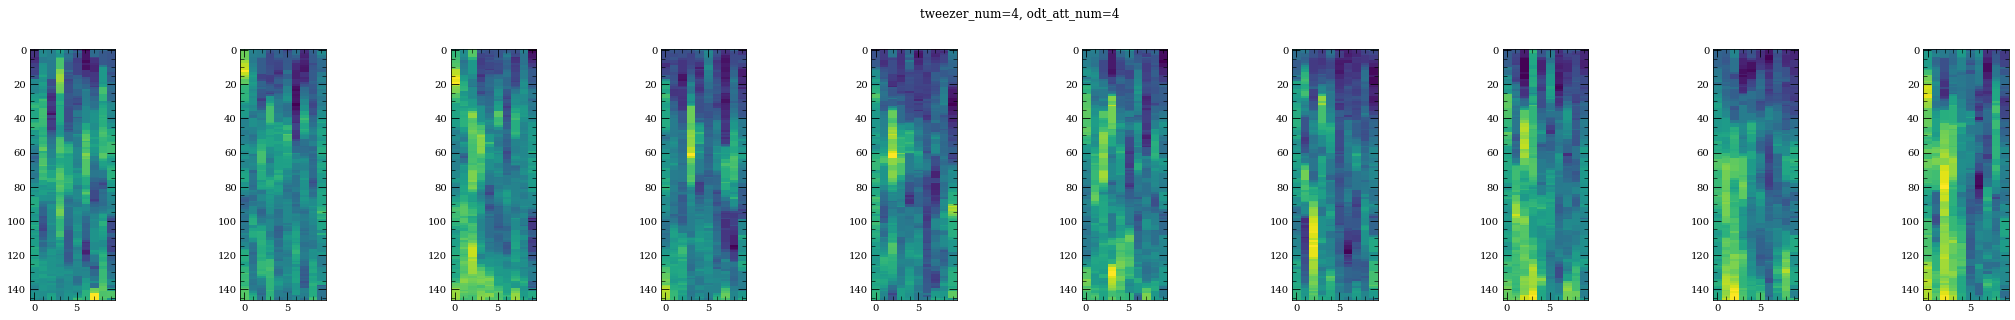

In [20]:
rolling_size = 30
brightness_rolling = xr.DataArray(coords=coords_list).isel(loop=slice(0, -rolling_size))
for loop in range(num_loops-rolling_size):
    brightness_rolling[loop, :, :, :, :] = np.nanmean(brightness_xr[loop:loop+rolling_size, :, :, :, :], 0)

for tweezer_num in range(num_tweezer):
    print(f'tweezer_num={tweezer_num}')
    for odt_att_num in range(num_odt_att):
        fig = plt.figure(figsize=(num_mol_freq*3, 4))
        fig.suptitle(f'tweezer_num={tweezer_num}, odt_att_num={odt_att_num}', y=1.1)
        for mol_freq_num in range(num_mol_freq):
#             print(mol_freq_num)
            ax = fig.add_subplot(1, num_mol_freq, mol_freq_num + 1)
            ax.imshow(brightness_rolling.isel(mol_freq=mol_freq_num, 
                                              tweezer=tweezer_num, odt_att=odt_att_num), aspect=0.2)
        fig.set_tight_layout(True)
    plt.show()

In [21]:
from scipy.optimize import curve_fit

phase_finding_dict = {0: (4, 2),
                      1: (5, 1),
                      2: (5, 2),
                      3: (7, 4)}

phase_coords_list = [('loop', range(num_loops-rolling_size)),
                     ('tweezer', tweezer_list),
                     ('pzt', pzt_list)]
phase_xr = xr.DataArray(coords=phase_coords_list)
k_xr = xr.DataArray(coords=phase_coords_list)


pzt_vals = phase_xr.coords['pzt'] - 5.5

def cos_fit_func(x, k, phase_offset, amplitude, offset):
    return amplitude * np.cos(k * x + phase_offset) + offset

for tweezer_num in [0, 1, 2, 3]:
    for loop_num in range(num_loops-rolling_size):
        if loop_num % 10 ==0:
            print(loop_num)
        mol_freq_num, odt_att_num = phase_finding_dict[tweezer_num]
        brightness_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                       tweezer=tweezer_num, odt_att=odt_att_num)
#         fit_dict = e6_fit(input_data=pzt_vals, output_data=brightness_data, fit_func=cos_fit_func,
#                           param_guess=[1.84, 0, 10000, 2200], 
#                           param_keys=['k', 'phase_offset', 'amplitude', 'offset'],
#                           method='lm', xtol=0, gtol=0, ftol=1e-9)
        
        popt, pcov = curve_fit(cos_fit_func, pzt_vals, brightness_data, p0=[1.84, 0, 10000, 2200])
        
        
#         k = fit_dict['k']['val']
#         phase_offset = fit_dict['phase_offset']['val'] % (2 * np.pi)
        k = popt[0]
        phase_offset = popt[1]
        amp = popt[2]
        if amp < 0:
            phase_offset += np.pi
        phase_offset = phase_offset % (2 * np.pi)

        pzt_phase_vals = k * pzt_vals + phase_offset
        phase_xr[loop_num, tweezer_num, :] = pzt_phase_vals
        k_xr[loop_num, tweezer_num, :] = k
        
#         print(f'k={k}')
#         print(f'phase_offset={phase_offset}')
#         print(f'amp={amp}')
#         plt.figure()
#         plt.plot(pzt_vals, brightness_data, linestyle='none', marker='.', markersize=10, color='black')
#         pzt_model = np.linspace(0, 5.5, 100)
# #         model_data = cos_fit_func(pzt_model, **fit_dict['kwargs'])
#         model_data = cos_fit_func(pzt_model, *popt)
#         plt.plot(pzt_model, model_data, color='red')
#         plt.show()


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


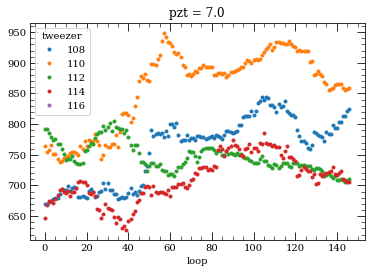

In [22]:
(200 * 2*np.pi/k_xr).isel(pzt=3).plot.line(x='loop', linestyle='none', marker='.')
plt.show()

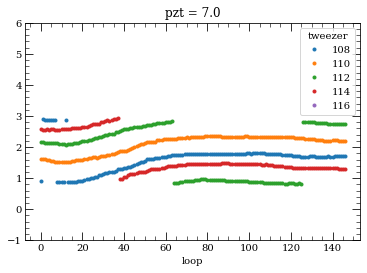

In [23]:
(phase_xr/(np.pi)).isel(pzt=3).plot.line(x='loop', linestyle='none', marker='.')
plt.ylim(-1, 6)
plt.show()
# (phase_xr/(2*np.pi)).isel(pzt=8).plot.line(x='loop', linestyle='none', marker='.')
# plt.ylim(-1, 3)
# plt.show()

tweezer_num=0, mol_freq_num=0


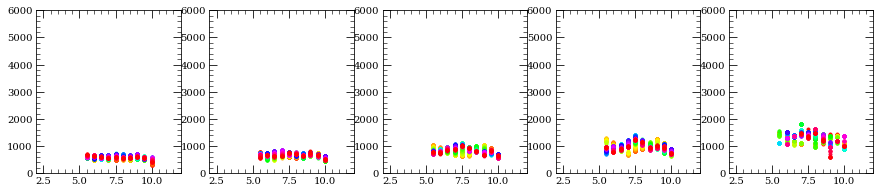

tweezer_num=0, mol_freq_num=1


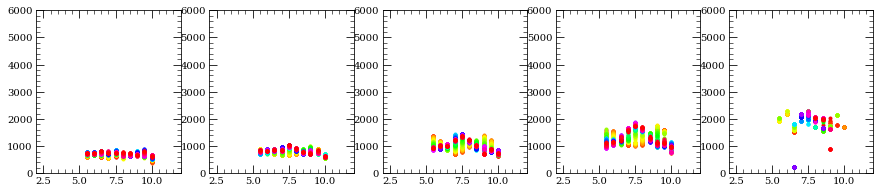

tweezer_num=0, mol_freq_num=2


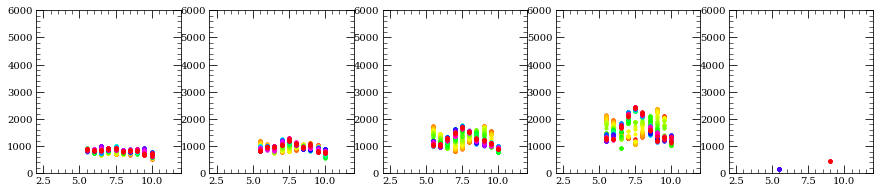

tweezer_num=0, mol_freq_num=3


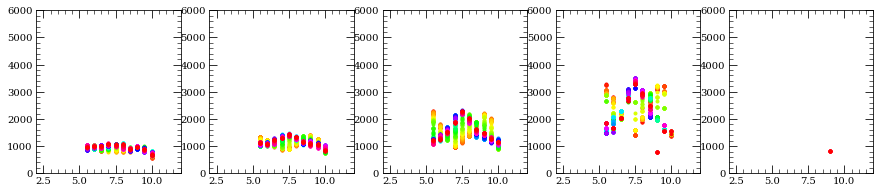

tweezer_num=0, mol_freq_num=4


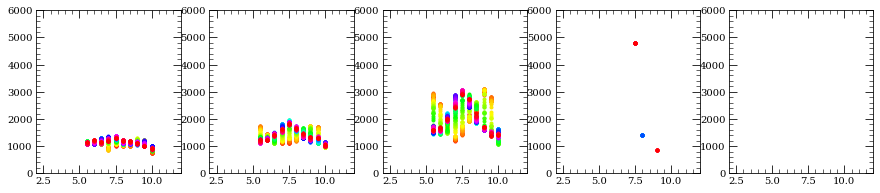

tweezer_num=0, mol_freq_num=5


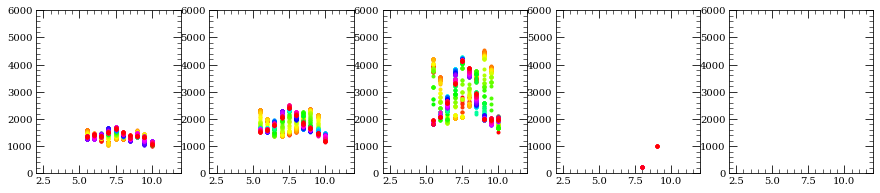

tweezer_num=0, mol_freq_num=6


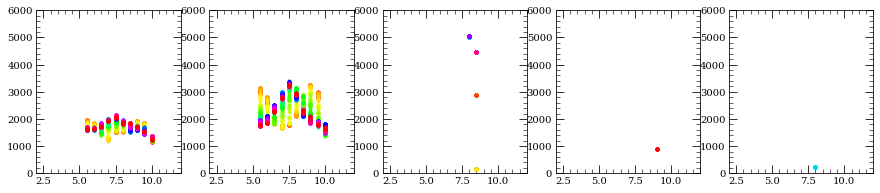

tweezer_num=0, mol_freq_num=7


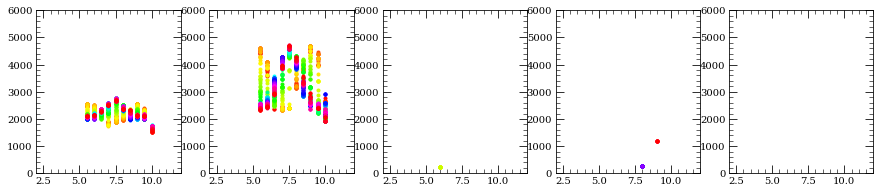

tweezer_num=0, mol_freq_num=8


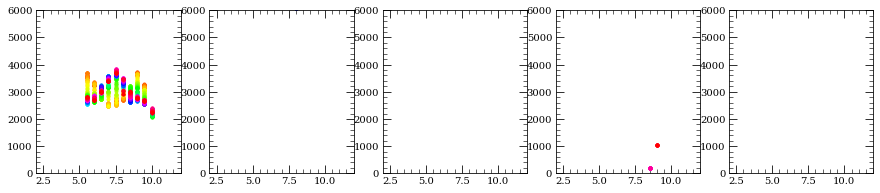

tweezer_num=0, mol_freq_num=9


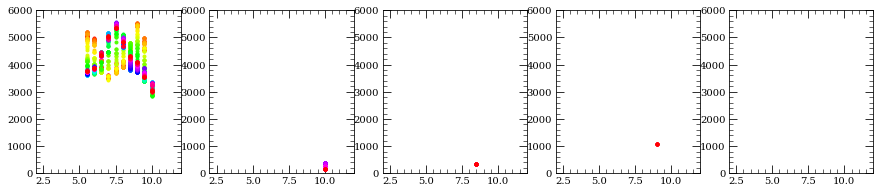

tweezer_num=1, mol_freq_num=0


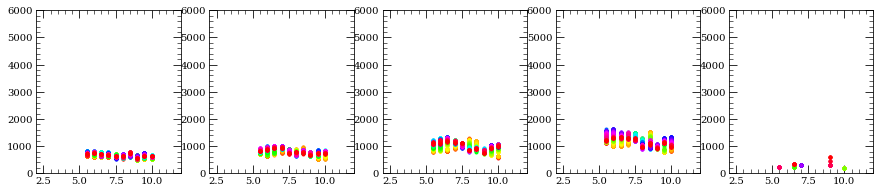

tweezer_num=1, mol_freq_num=1


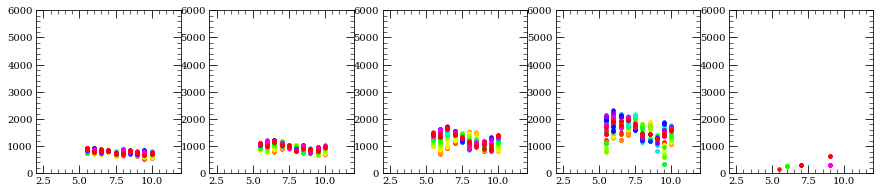

tweezer_num=1, mol_freq_num=2


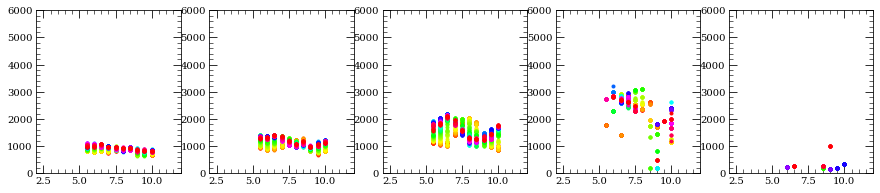

tweezer_num=1, mol_freq_num=3


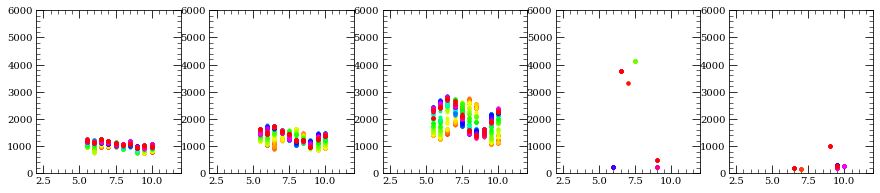

tweezer_num=1, mol_freq_num=4


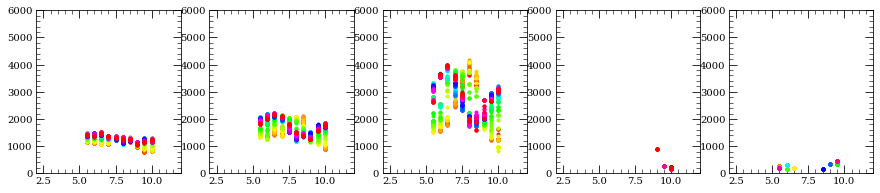

tweezer_num=1, mol_freq_num=5


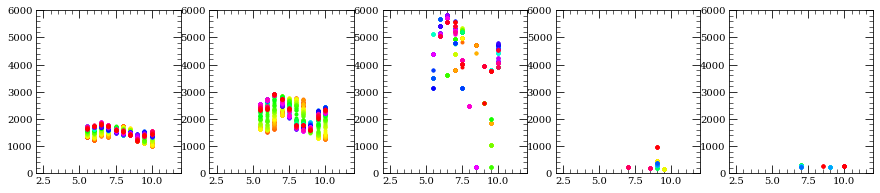

tweezer_num=1, mol_freq_num=6


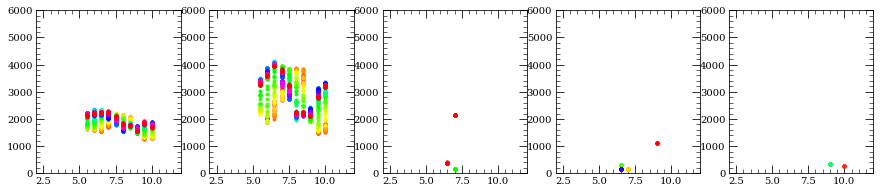

tweezer_num=1, mol_freq_num=7


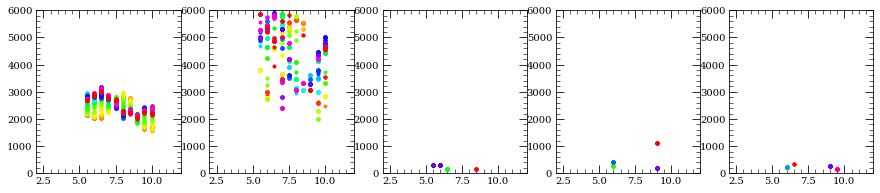

tweezer_num=1, mol_freq_num=8


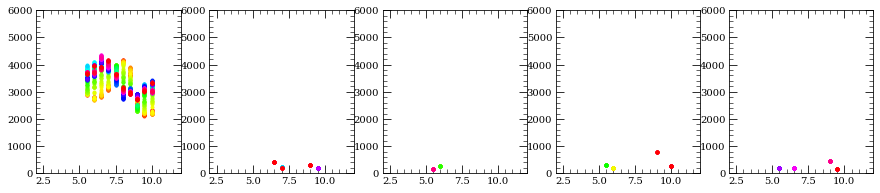

tweezer_num=1, mol_freq_num=9


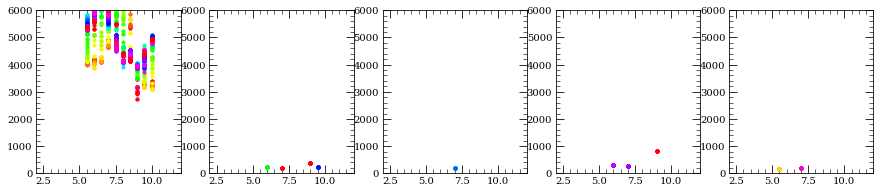

tweezer_num=2, mol_freq_num=0


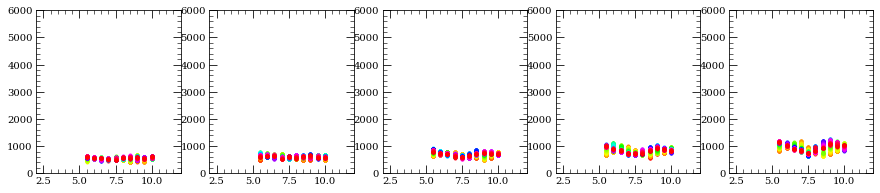

tweezer_num=2, mol_freq_num=1


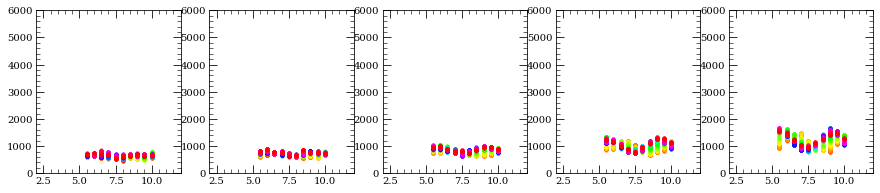

tweezer_num=2, mol_freq_num=2


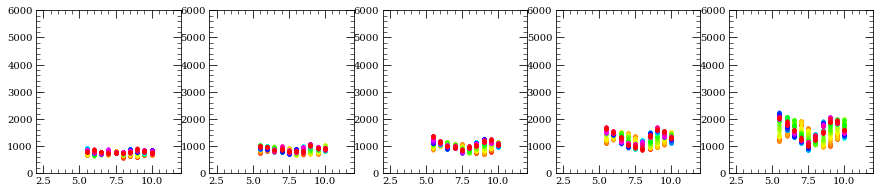

tweezer_num=2, mol_freq_num=3


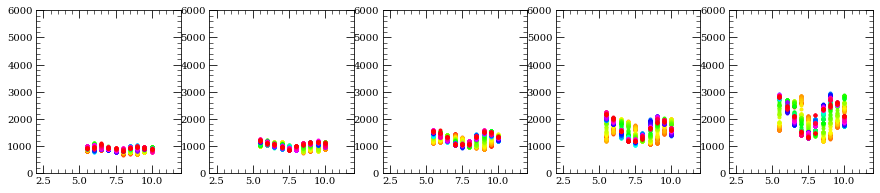

tweezer_num=2, mol_freq_num=4


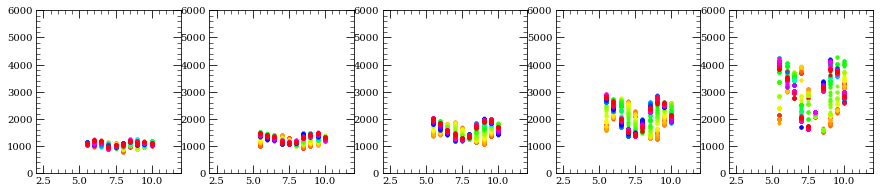

tweezer_num=2, mol_freq_num=5


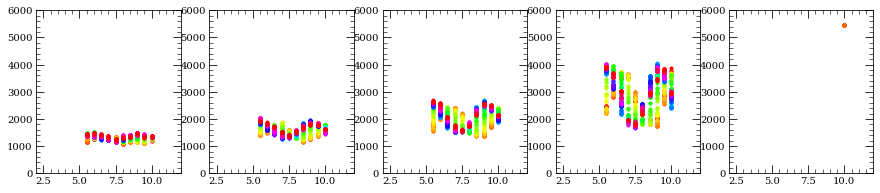

tweezer_num=2, mol_freq_num=6


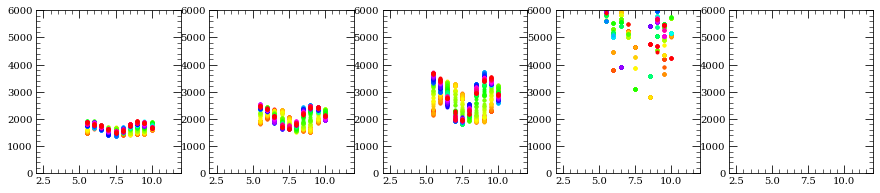

tweezer_num=2, mol_freq_num=7


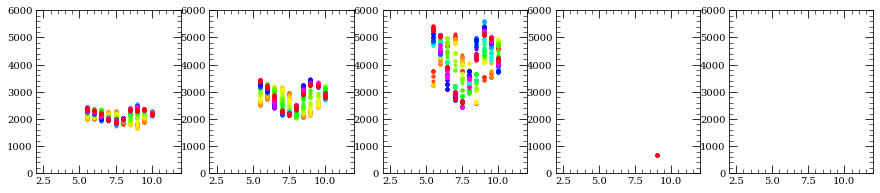

tweezer_num=2, mol_freq_num=8


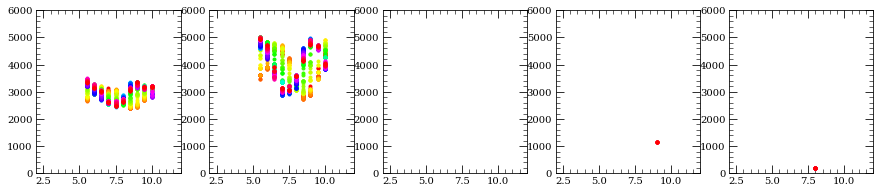

tweezer_num=2, mol_freq_num=9


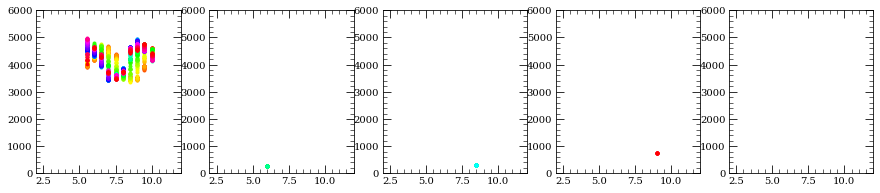

tweezer_num=3, mol_freq_num=0


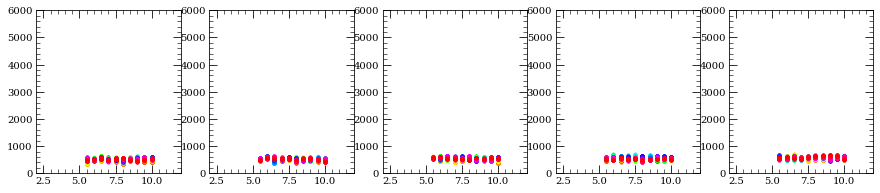

tweezer_num=3, mol_freq_num=1


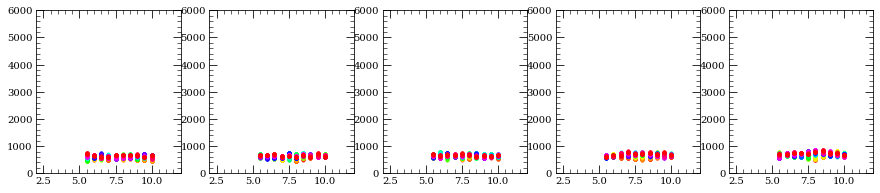

tweezer_num=3, mol_freq_num=2


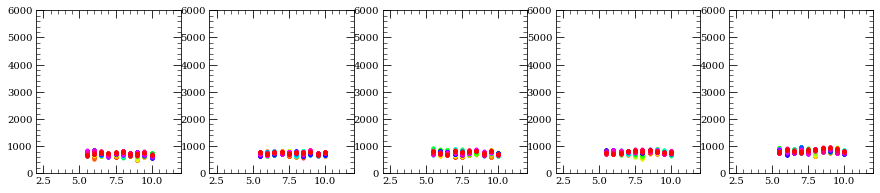

tweezer_num=3, mol_freq_num=3


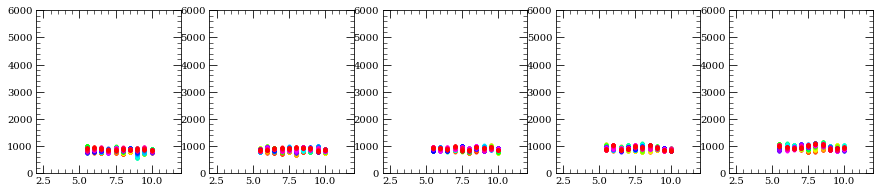

tweezer_num=3, mol_freq_num=4


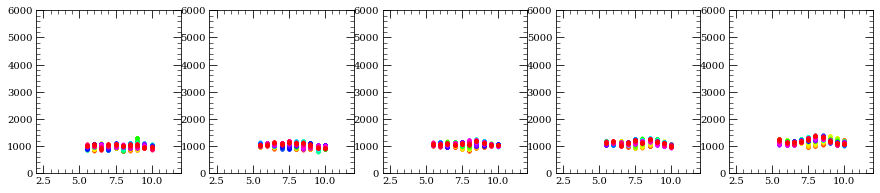

tweezer_num=3, mol_freq_num=5


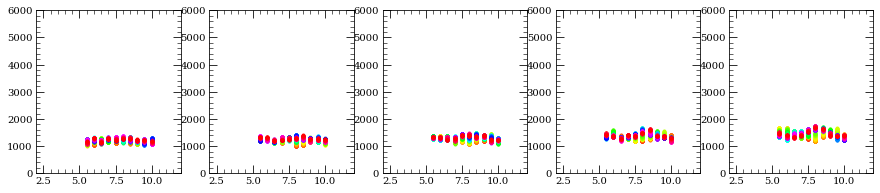

tweezer_num=3, mol_freq_num=6


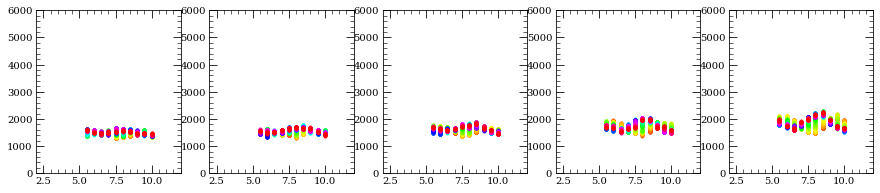

tweezer_num=3, mol_freq_num=7


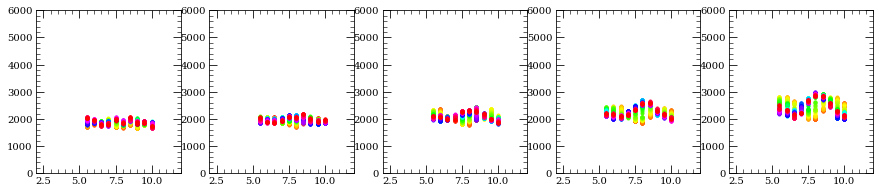

tweezer_num=3, mol_freq_num=8


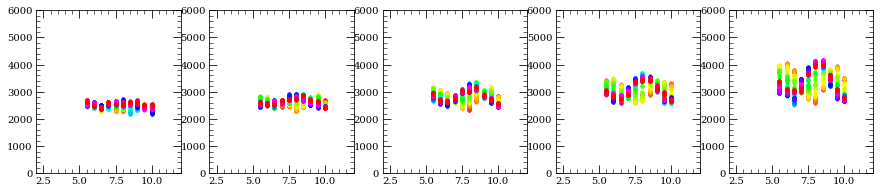

tweezer_num=3, mol_freq_num=9


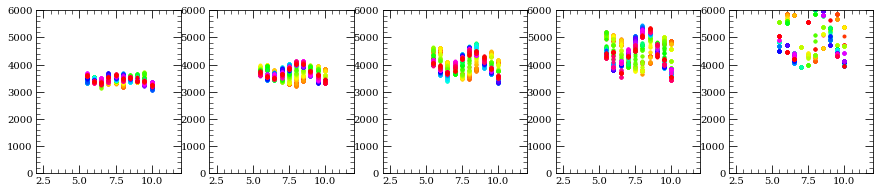

In [24]:
from matplotlib.colors import hsv_to_rgb
hue_list = np.linspace(0, 1, num_loops-rolling_size)

for tweezer_num in [0, 1, 2, 3]:
    for mol_freq_num in range(num_mol_freq):
        fig = plt.figure(figsize=(num_odt_att * 3, 3))
        print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}')
        for odt_att_num in range(num_odt_att):
#             print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}, odt_att_num={odt_att_num}')
            ax = fig.add_subplot(1, num_odt_att, odt_att_num + 1)
            for loop_num in range(num_loops-rolling_size):
                bright_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                                      tweezer=tweezer_num, odt_att=odt_att_num)
                pzt_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                                      tweezer=tweezer_num, odt_att=odt_att_num).coords['pzt']
#                 pzt_data = phase_xr.isel(loop=loop_num, tweezer=tweezer_num)
                color = hsv_to_rgb((hue_list[loop_num], 1, 1))
                ax.plot(pzt_data, bright_data, '.', color=color)
                ax.set_ylim(0, 6000)
                ax.set_xlim(2, 12)
        plt.show()

tweezer_num=0, mol_freq_num=0


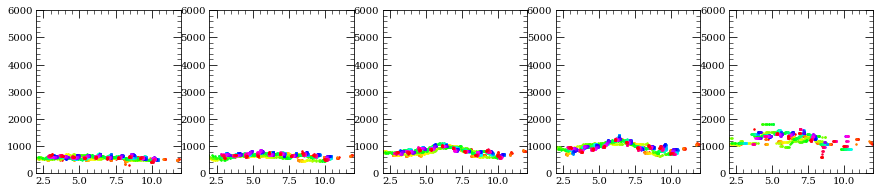

tweezer_num=0, mol_freq_num=1


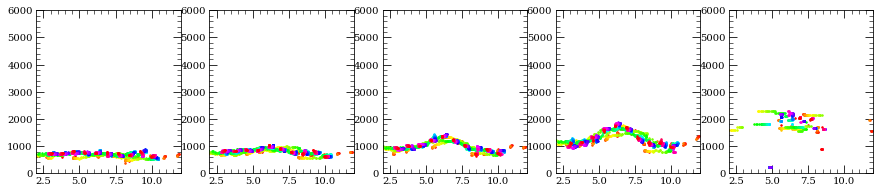

tweezer_num=0, mol_freq_num=2


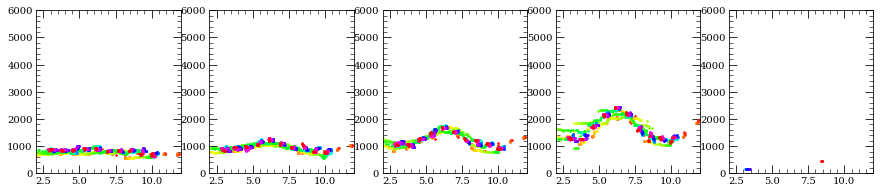

tweezer_num=0, mol_freq_num=3


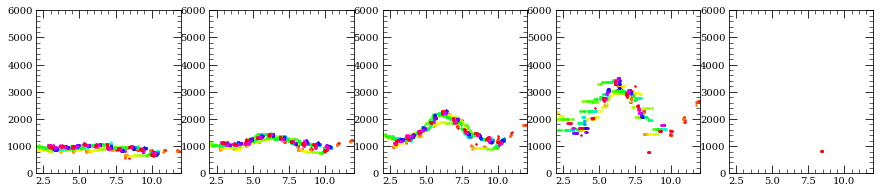

tweezer_num=0, mol_freq_num=4


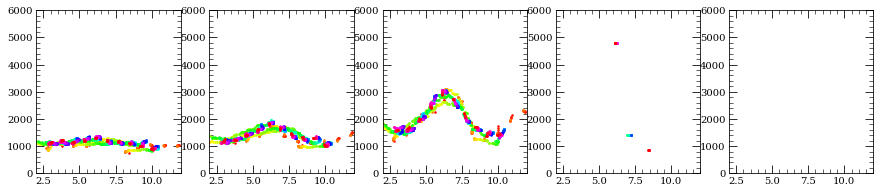

tweezer_num=0, mol_freq_num=5


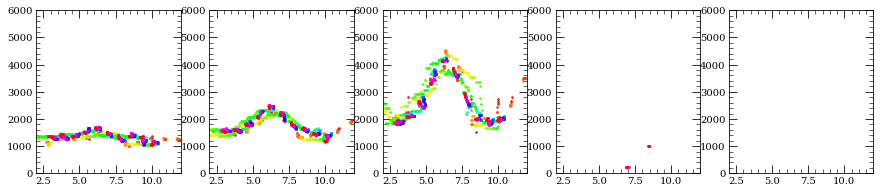

tweezer_num=0, mol_freq_num=6


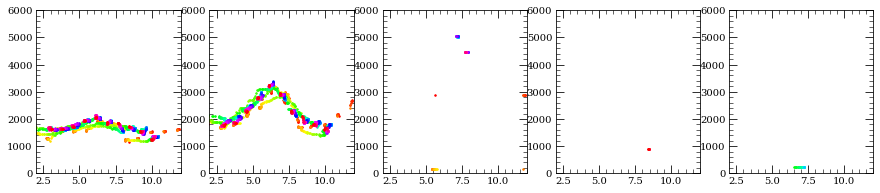

tweezer_num=0, mol_freq_num=7


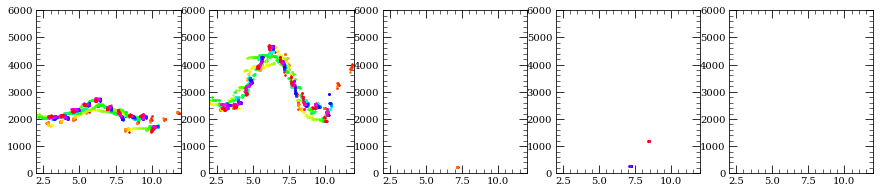

tweezer_num=0, mol_freq_num=8


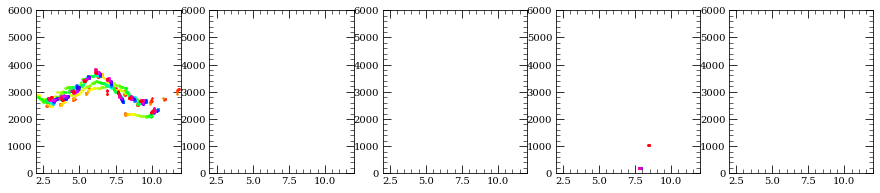

tweezer_num=0, mol_freq_num=9


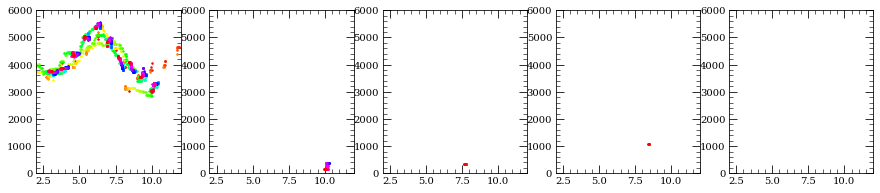

tweezer_num=1, mol_freq_num=0


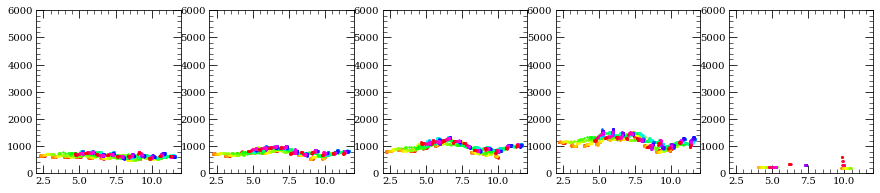

tweezer_num=1, mol_freq_num=1


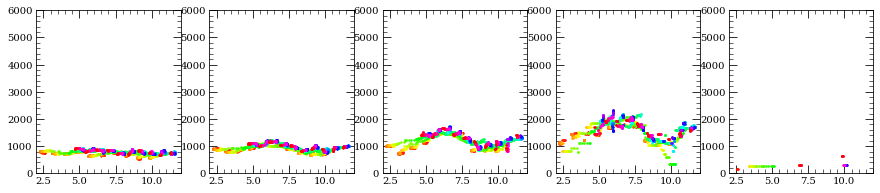

tweezer_num=1, mol_freq_num=2


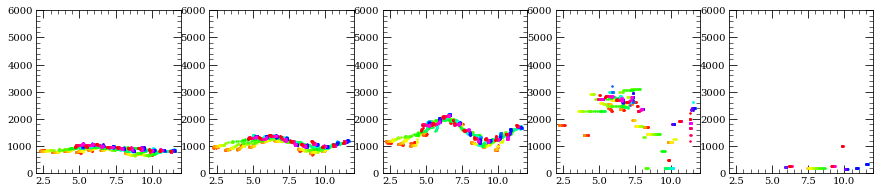

tweezer_num=1, mol_freq_num=3


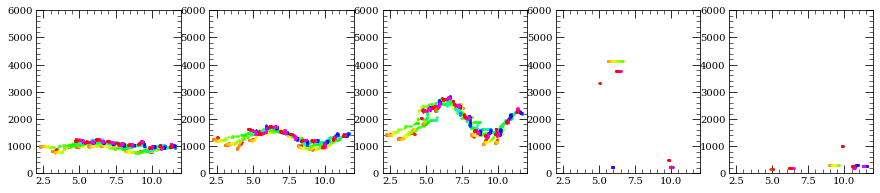

tweezer_num=1, mol_freq_num=4


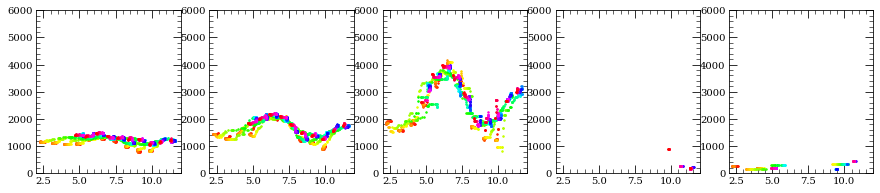

tweezer_num=1, mol_freq_num=5


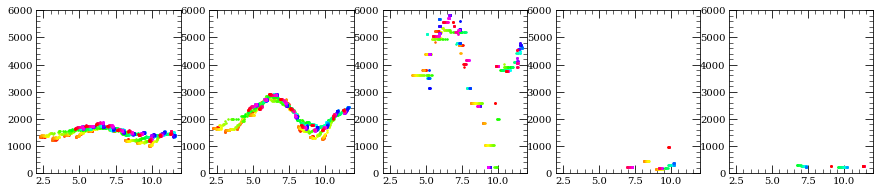

tweezer_num=1, mol_freq_num=6


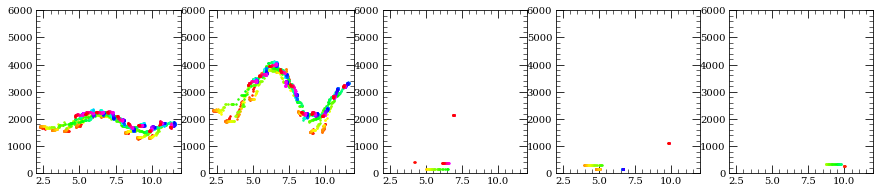

tweezer_num=1, mol_freq_num=7


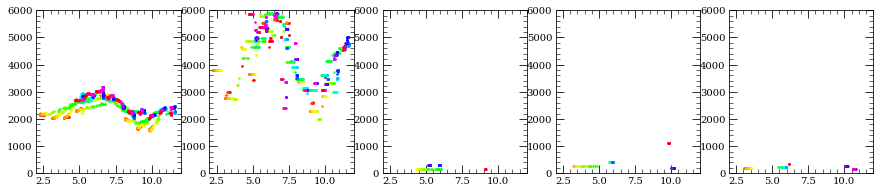

tweezer_num=1, mol_freq_num=8


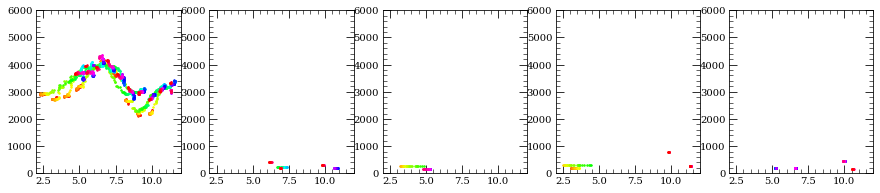

tweezer_num=1, mol_freq_num=9


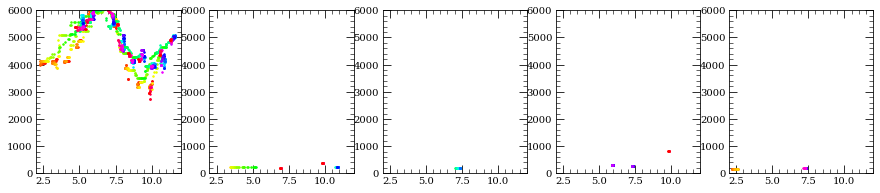

tweezer_num=2, mol_freq_num=0


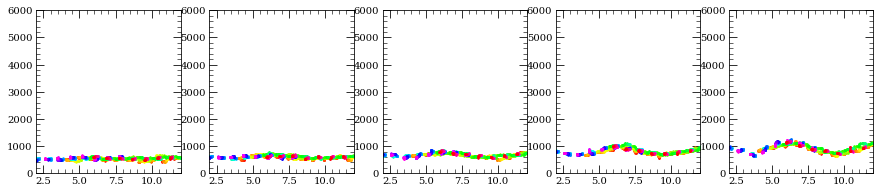

tweezer_num=2, mol_freq_num=1


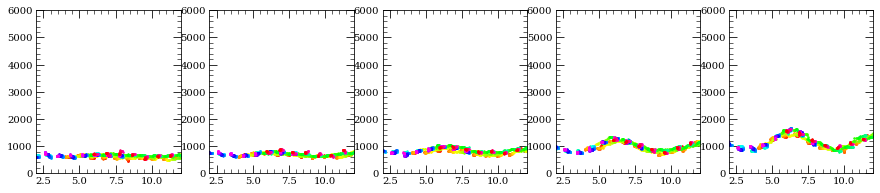

tweezer_num=2, mol_freq_num=2


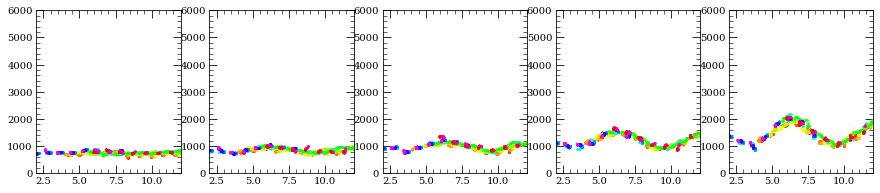

tweezer_num=2, mol_freq_num=3


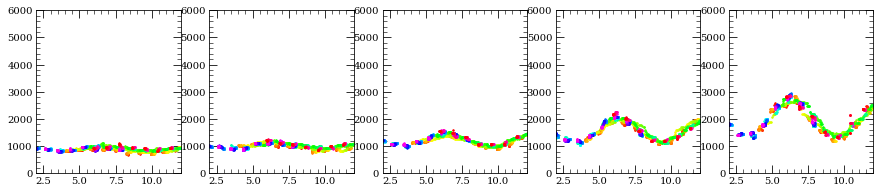

tweezer_num=2, mol_freq_num=4


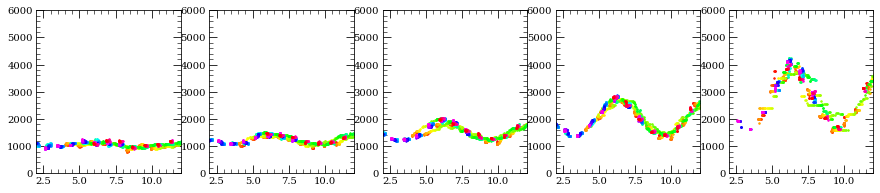

tweezer_num=2, mol_freq_num=5


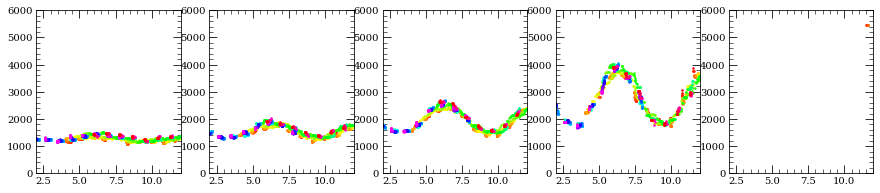

tweezer_num=2, mol_freq_num=6


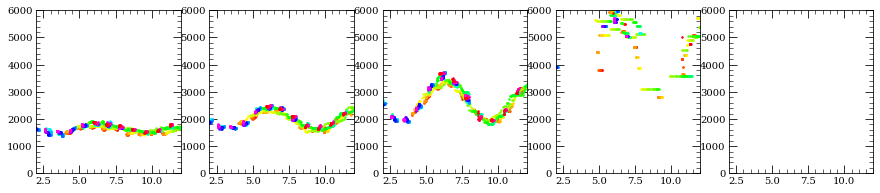

tweezer_num=2, mol_freq_num=7


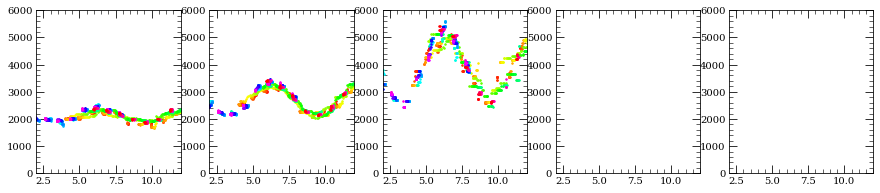

tweezer_num=2, mol_freq_num=8


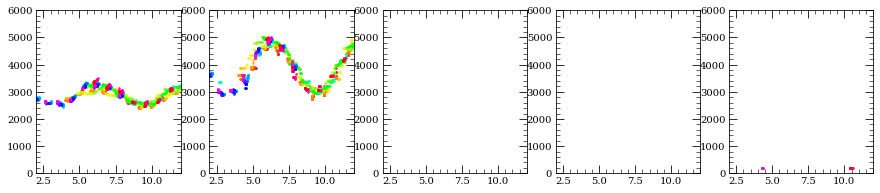

tweezer_num=2, mol_freq_num=9


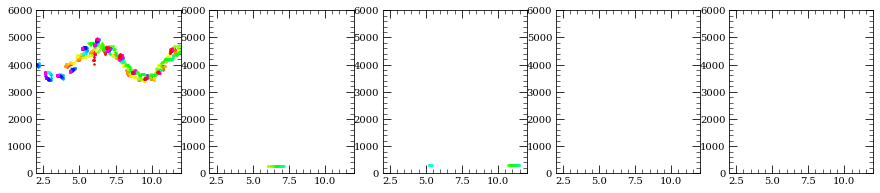

tweezer_num=3, mol_freq_num=0


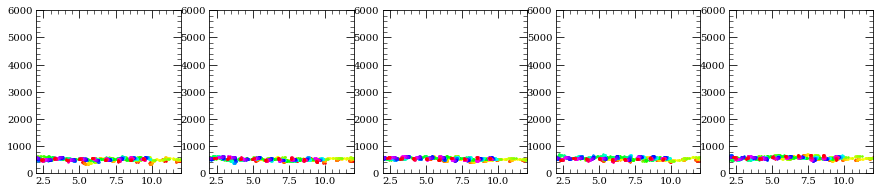

tweezer_num=3, mol_freq_num=1


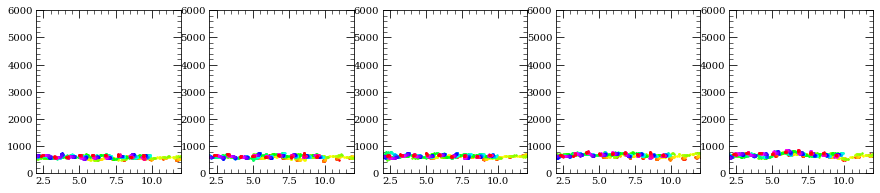

tweezer_num=3, mol_freq_num=2


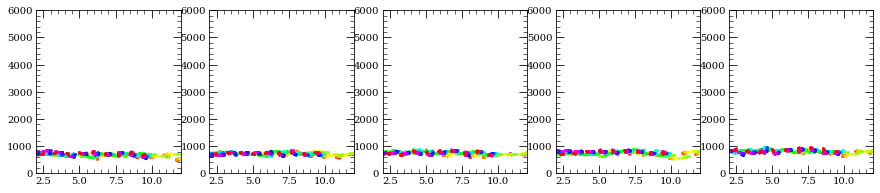

tweezer_num=3, mol_freq_num=3


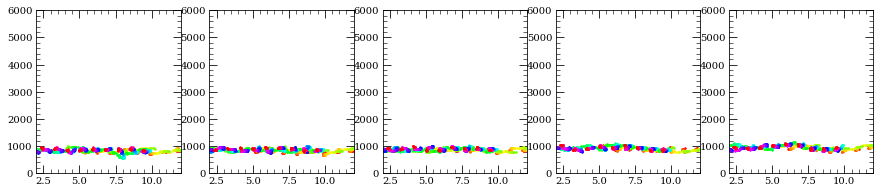

tweezer_num=3, mol_freq_num=4


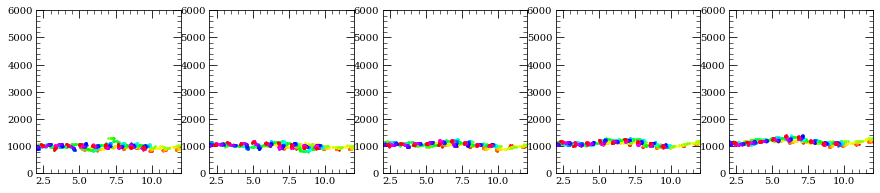

tweezer_num=3, mol_freq_num=5


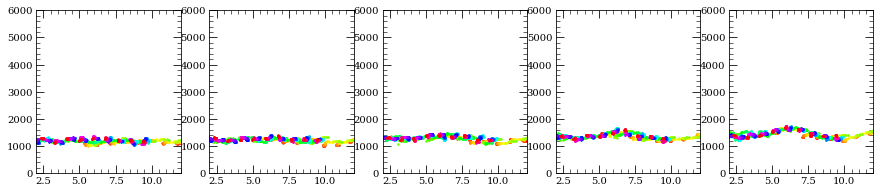

tweezer_num=3, mol_freq_num=6


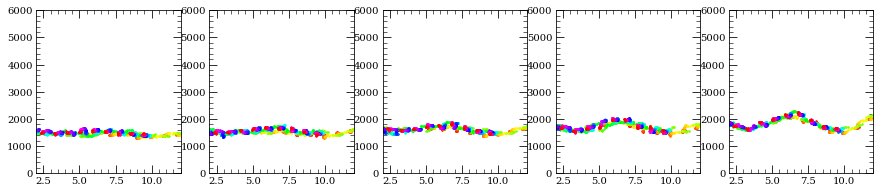

tweezer_num=3, mol_freq_num=7


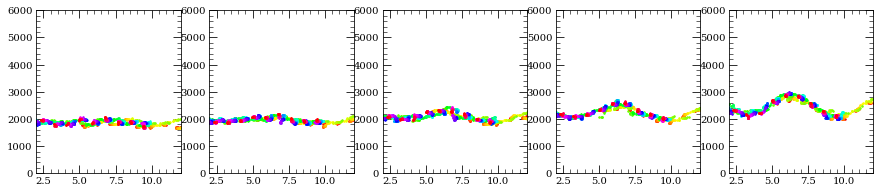

tweezer_num=3, mol_freq_num=8


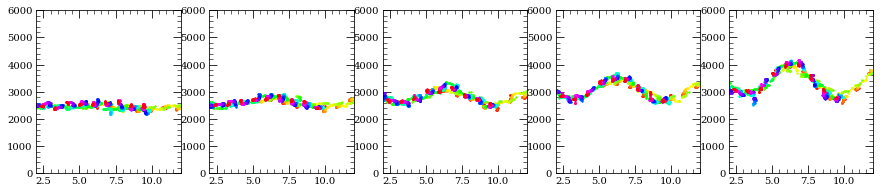

tweezer_num=3, mol_freq_num=9


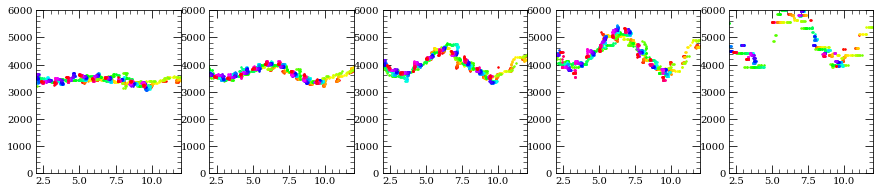

In [25]:
from matplotlib.colors import hsv_to_rgb
hue_list = np.linspace(0, 1, num_loops-rolling_size)

for tweezer_num in [0, 1, 2, 3]:
    for mol_freq_num in range(num_mol_freq):
        fig = plt.figure(figsize=(num_odt_att * 3, 3))
        print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}')
        for odt_att_num in range(num_odt_att):
#             print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}, odt_att_num={odt_att_num}')
            ax = fig.add_subplot(1, num_odt_att, odt_att_num + 1)
            for loop_num in range(num_loops-rolling_size):
#                 print(loop_num)
                bright_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                                      tweezer=tweezer_num, odt_att=odt_att_num)
#                 pzt_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
#                                                       tweezer=tweezer_num, odt_att=odt_att_num).coords['pzt']
                pzt_data = phase_xr.isel(loop=loop_num, tweezer=tweezer_num)
                color = hsv_to_rgb((hue_list[loop_num], 1, 1))
                ax.plot(pzt_data, bright_data, linestyle='none', marker='.', color=color, alpha=1, markersize=3)
                ax.set_ylim(0, 6000)
                ax.set_xlim(2, 12)
        plt.show()

tweezer_num=0, mol_freq_num=0


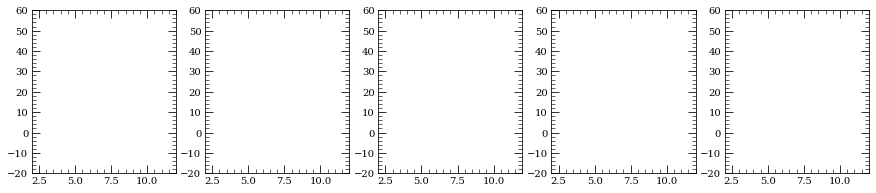

tweezer_num=0, mol_freq_num=1


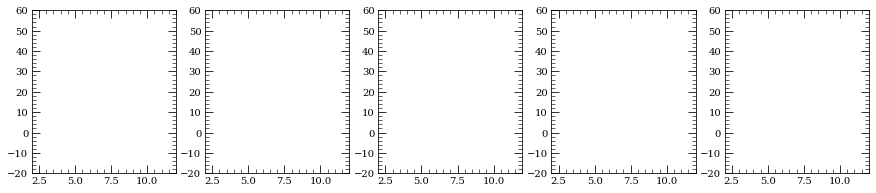

tweezer_num=0, mol_freq_num=2


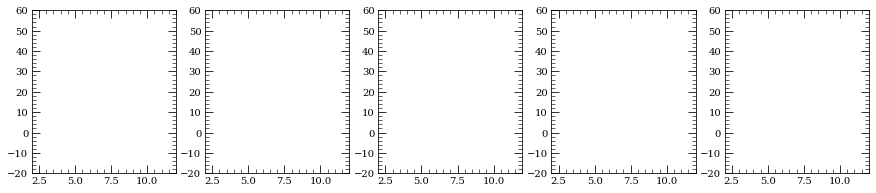

tweezer_num=0, mol_freq_num=3


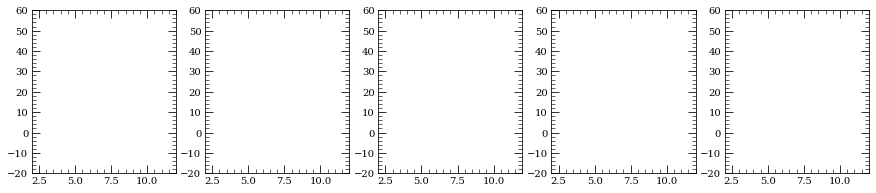

tweezer_num=0, mol_freq_num=4


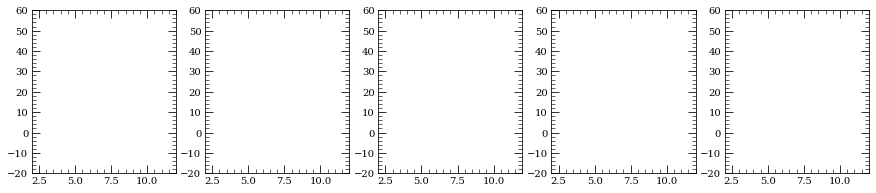

tweezer_num=0, mol_freq_num=5


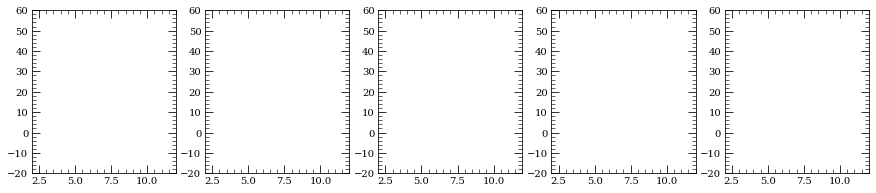

tweezer_num=0, mol_freq_num=6


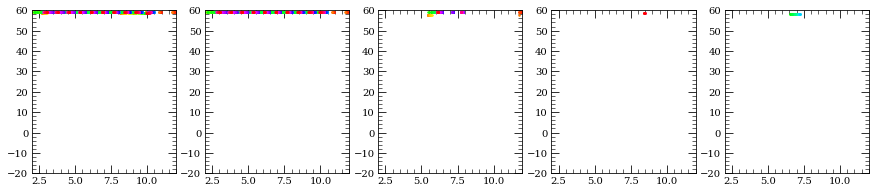

tweezer_num=0, mol_freq_num=7


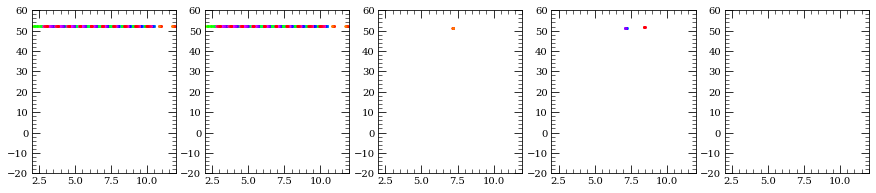

tweezer_num=0, mol_freq_num=8


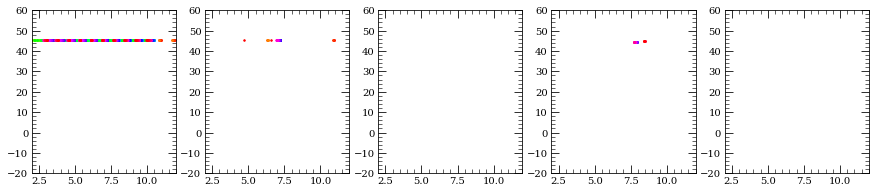

tweezer_num=0, mol_freq_num=9


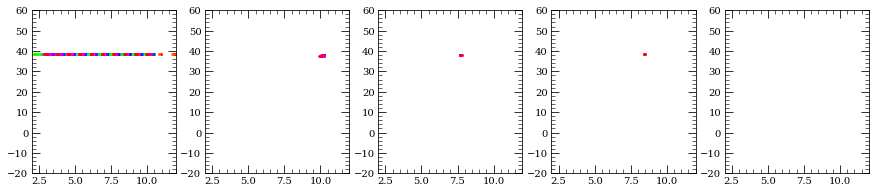

tweezer_num=1, mol_freq_num=0


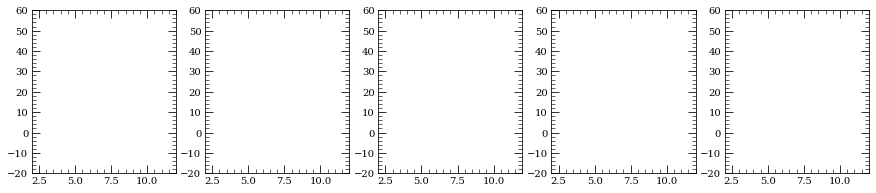

tweezer_num=1, mol_freq_num=1


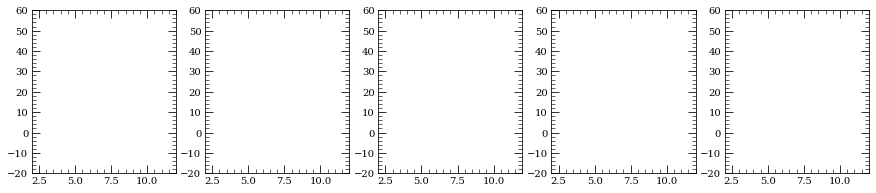

tweezer_num=1, mol_freq_num=2


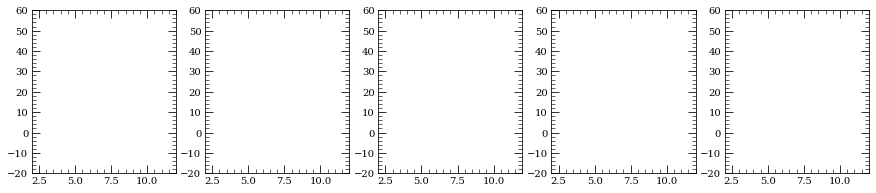

tweezer_num=1, mol_freq_num=3


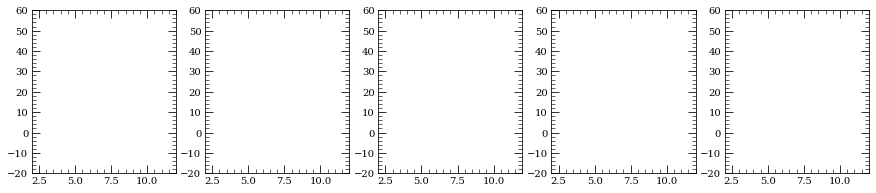

tweezer_num=1, mol_freq_num=4


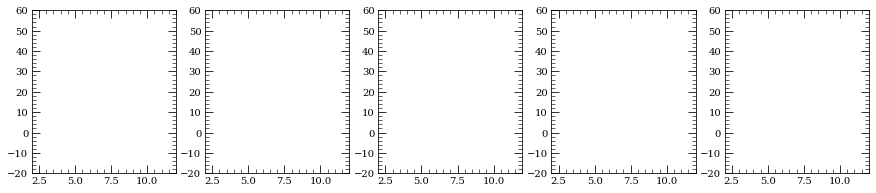

tweezer_num=1, mol_freq_num=5


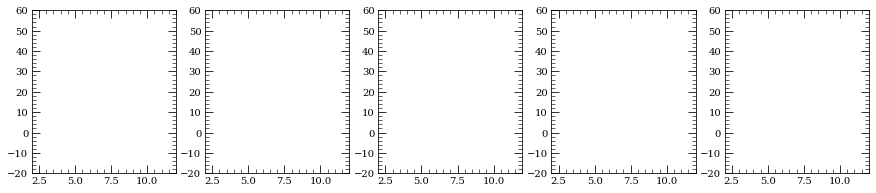

tweezer_num=1, mol_freq_num=6


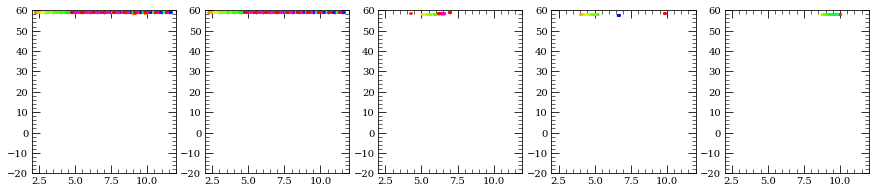

tweezer_num=1, mol_freq_num=7


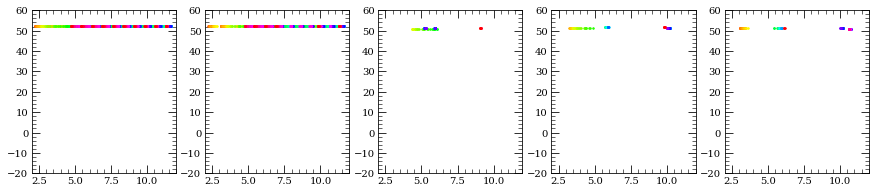

tweezer_num=1, mol_freq_num=8


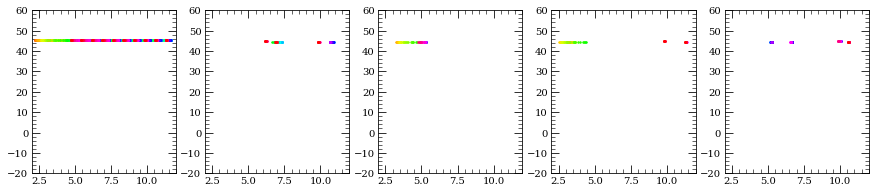

tweezer_num=1, mol_freq_num=9


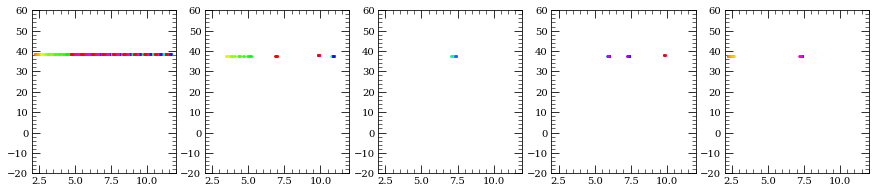

tweezer_num=2, mol_freq_num=0


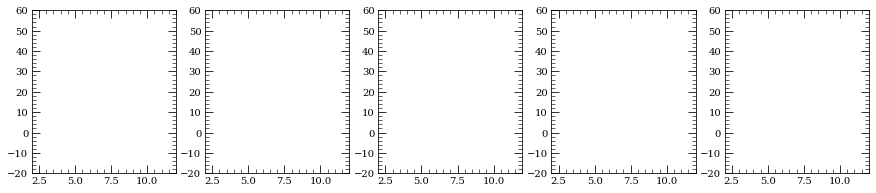

tweezer_num=2, mol_freq_num=1


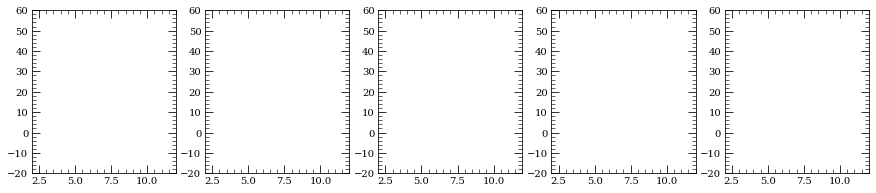

tweezer_num=2, mol_freq_num=2


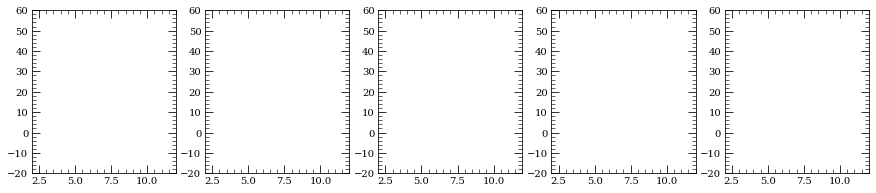

tweezer_num=2, mol_freq_num=3


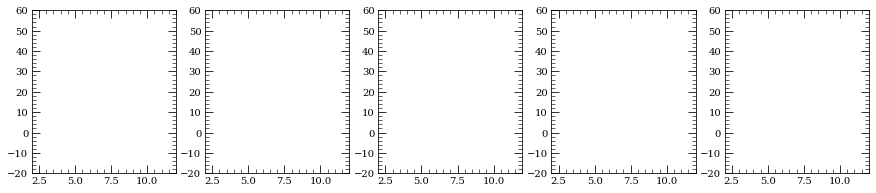

tweezer_num=2, mol_freq_num=4


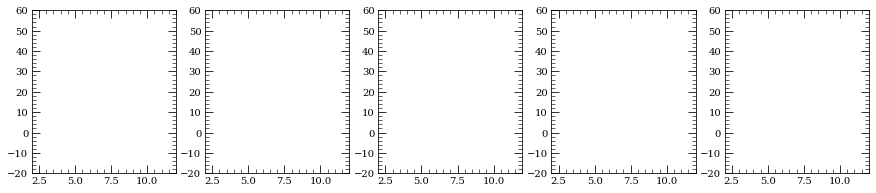

tweezer_num=2, mol_freq_num=5


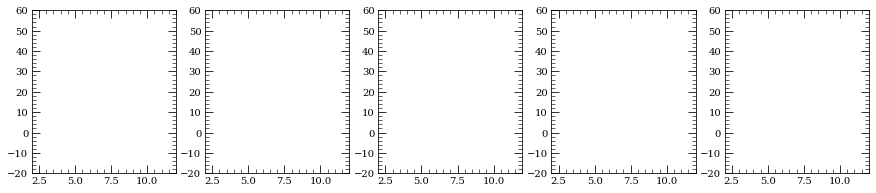

tweezer_num=2, mol_freq_num=6


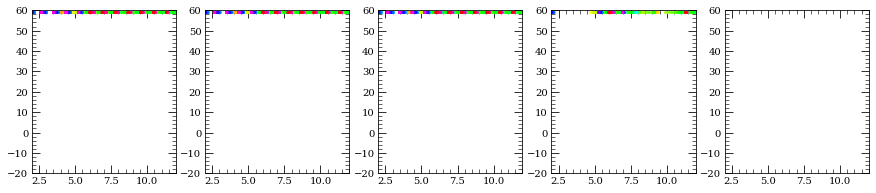

tweezer_num=2, mol_freq_num=7


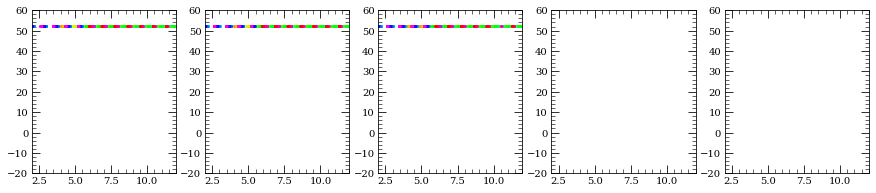

tweezer_num=2, mol_freq_num=8


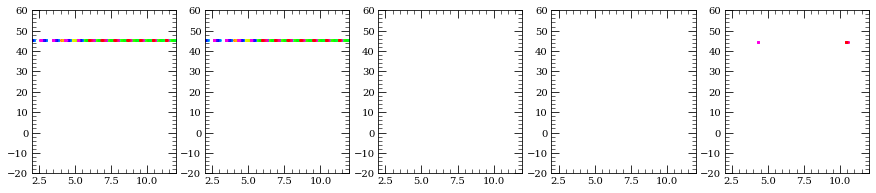

tweezer_num=2, mol_freq_num=9


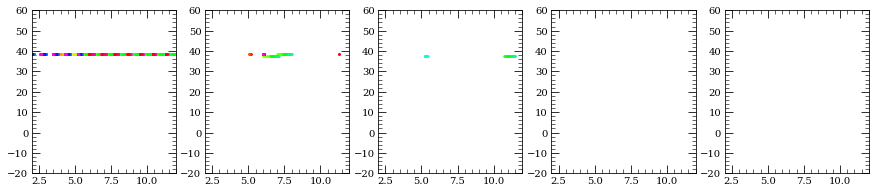

tweezer_num=3, mol_freq_num=0


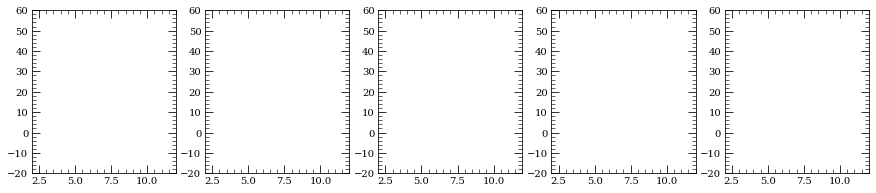

tweezer_num=3, mol_freq_num=1


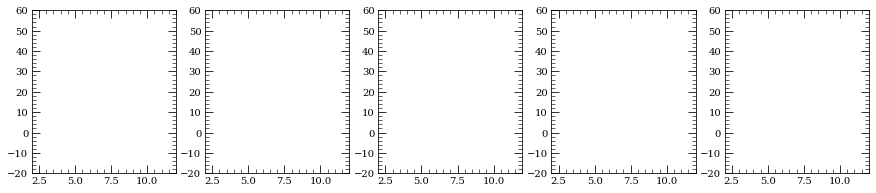

tweezer_num=3, mol_freq_num=2


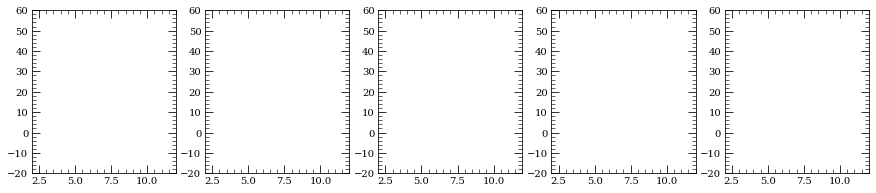

tweezer_num=3, mol_freq_num=3


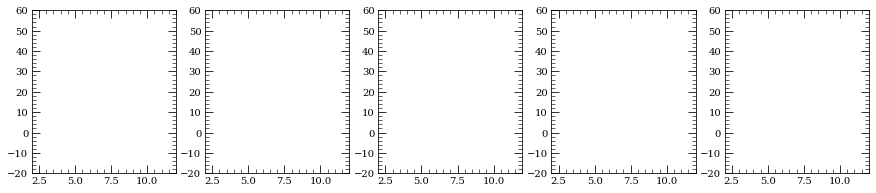

tweezer_num=3, mol_freq_num=4


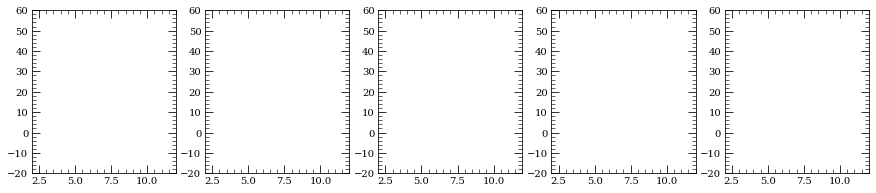

tweezer_num=3, mol_freq_num=5


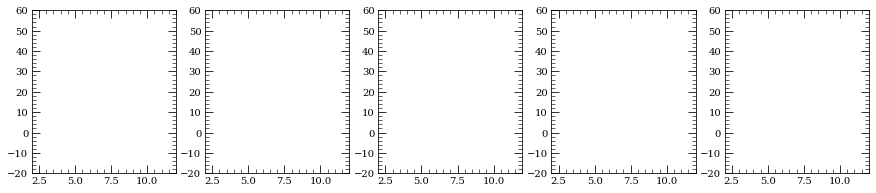

tweezer_num=3, mol_freq_num=6


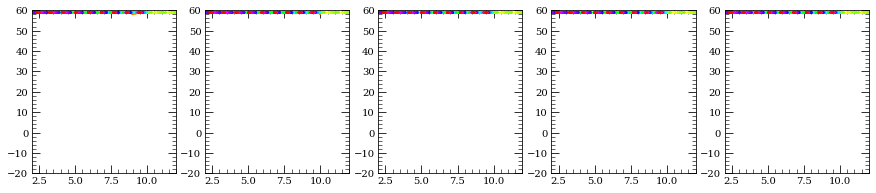

tweezer_num=3, mol_freq_num=7


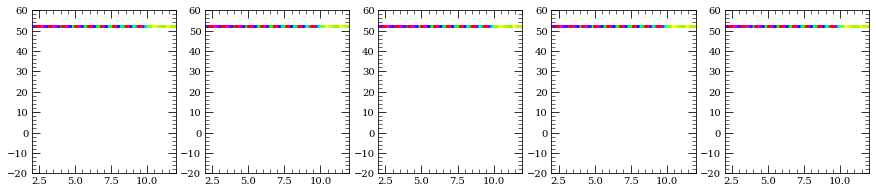

tweezer_num=3, mol_freq_num=8


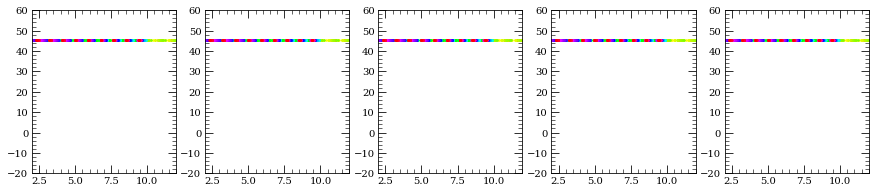

tweezer_num=3, mol_freq_num=9


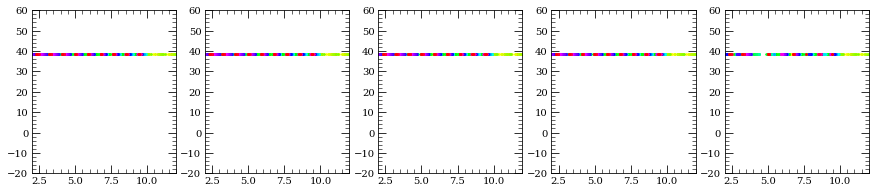

In [26]:
from matplotlib.colors import hsv_to_rgb
hue_list = np.linspace(0, 1, num_loops-rolling_size)

for tweezer_num in [0, 1, 2, 3]:
    for mol_freq_num in range(num_mol_freq):
        fig = plt.figure(figsize=(num_odt_att * 3, 3))
        print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}')
        for odt_att_num in range(num_odt_att):
#             print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}, odt_att_num={odt_att_num}')
            ax = fig.add_subplot(1, num_odt_att, odt_att_num + 1)
#             for loop_num in range(num_loops-rolling_size):
            for loop_num in range(0, num_loops - rolling_size):
#                 print(loop_num)
                bright_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                                      tweezer=tweezer_num, odt_att=odt_att_num)
                shift_data = brightness_to_shift_cal(bright_data, mol_freq_list[mol_freq_num])
#                 pzt_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
#                                                       tweezer=tweezer_num, odt_att=odt_att_num).coords['pzt']
                pzt_data = phase_xr.isel(loop=loop_num, tweezer=tweezer_num)
                color = hsv_to_rgb((hue_list[loop_num], 1, 1))
                ax.plot(pzt_data, shift_data, linestyle='none', marker='.', color=color, alpha=1, markersize=3)
                ax.set_ylim(-20, 60)
                ax.set_xlim(2, 12)
        plt.show()

contrast = 0.001045810548133171
contrast = 0.0009225909007301269
contrast = 0.0009254624541667087
contrast = 0.00043989191020744314
contrast = 9.778346130383807e-05


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

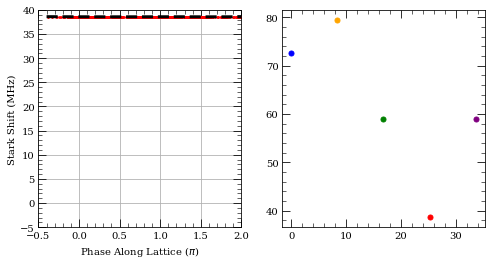

In [27]:
from matplotlib.colors import hsv_to_rgb
hue_list = np.linspace(0, 1, num_loops-rolling_size)

fig = plt.figure(figsize=(2 * 4, 4))
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

mol_freq_num_list = [4, 3, 6, 9, 6]
color_list = ['blue', 'orange', 'green', 'red', 'purple']
offset_list = []
for tweezer_num in [0, 1, 2, 3, 4]:
    mol_freq_num = mol_freq_num_list[tweezer_num]
#     print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}')
    odt_att_num = 2
#             print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}, odt_att_num={odt_att_num}')
#             for loop_num in range(num_loops-rolling_size):
    shift_data_tot = []
    pzt_data_tot = []
    for loop_num in range(0, num_loops - rolling_size):
#                 print(loop_num)
        bright_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                              tweezer=tweezer_num, odt_att=odt_att_num)
        shift_data = brightness_to_shift_cal(bright_data, mol_freq_list[mol_freq_num])
        shift_data_tot += list(shift_data)
        if tweezer_num is not 4:
            pzt_data = phase_xr.isel(loop=loop_num, tweezer=tweezer_num)
            pguess = [2*np.pi/10, 0, 5, 10]
        else:
            pzt_data = phase_xr.isel(loop=loop_num, tweezer=3)
            pguess = [2*np.pi/10, 0, 0, 0]
        pzt_data_tot += list(pzt_data)
    
    shift_data_tot = np.array(shift_data_tot)
    pzt_data_tot = np.array(pzt_data_tot)
    
    mask = np.logical_not(np.isnan(np.array(shift_data_tot) ))
    popt, pcov = curve_fit(cos_fit_func, pzt_data_tot[mask], shift_data_tot[mask], p0=pguess)
    offset = popt[3]
    offset_list.append(offset)
    offset_err = np.sqrt(pcov[3, 3])
    print(f'contrast = {np.abs(popt[2])/popt[3]}')
    model_phase = np.linspace(0, 14, 200)
    model_shift = cos_fit_func(model_phase, *popt)
    
    color = color_list[tweezer_num]
    ax.plot((pzt_data_tot-2)/10*2, shift_data_tot, linestyle='none', color=color, marker='.', alpha=1, markersize=3)
    ax.plot((model_phase-2)/10*2, model_shift, linestyle='--', color='black', alpha=1, linewidth=3)
    ax2.errorbar(tweezer_num*4.2*2, offset, yerr=offset_err, color=color, linestyle='none', marker='.', markersize=10)
    
ax.set_ylim(-5, 40)
ax.set_xlim(-0.5, 2)
ax.grid(True)
ax.set_xlabel('Phase Along Lattice ($\pi$)')
ax.set_ylabel('Stark Shift (MHz)')

popt, pcov = curve_fit(gaussian, [0, 1, 2, 3, 4], offset_list, p0=[1, 5, 1])
print(f'sigma={popt[2]*4.2*2}')
model_pos = np.linspace(-1, 4, 100)
model_offset = gaussian(model_pos, *popt)
ax2.plot(model_pos*4.2*2, model_offset, linestyle='--', color='black')
ax2.set_ylim(-5, 40)
ax2.grid(True)
ax2.set_xlabel('Radial Position ($\mu$m)')


plt.show()




In [ ]:
(phase_xr/np.pi).isel(pzt=0).plot.line(x='loop', linestyle='none', marker='.')

In [ ]:
brightness_rolling.coords['pzt']

In [ ]:
brightness_rolling.isel(loop=slice(40, None), tweezer=1, odt_att=0).mean(dim='loop').plot.line(x='mol_freq', linestyle='--', marker='.')

In [ ]:
for mol_freq_num, mol_freq in enumerate(mol_freq_list):
    data = det_xr_rolling.isel(loop=slice(40, None), tweezer=1, odt_att=0, mol_freq=mol_freq_num).mean(dim='loop')
    data_ref = det_xr_rolling.isel(loop=slice(40, None), tweezer=4, odt_att=0, mol_freq=mol_freq_num).mean(dim='loop')

    plt.plot(data - mol_freq + dftweezer, linestyle='--', marker='.', markersize=10)
    legend_strings = [f'{mol_freq:.0f}' for mol_freq in mol_freq_list]
    plt.legend(legend_strings)
plt.show()
    
for mol_freq_num, mol_freq in enumerate(mol_freq_list):
    data_ref = det_xr_rolling.isel(loop=slice(40, None), tweezer=4, odt_att=0, mol_freq=mol_freq_num).mean(dim='loop')
    plt.plot(data_ref)
    legend_strings = [f'{mol_freq:.0f}' for mol_freq in mol_freq_list]
    plt.legend(legend_strings)
plt.show()

In [ ]:
det_xr_rolling.isel(mol_freq=9, tweezer=1, odt_att=0).plot()

In [ ]:
det_xr_rolling.isel(loop=130, mol_freq=9, tweezer=1, odt_att=0).plot()
plt.show()
brightness_rolling.isel(loop=130, mol_freq=9, tweezer=1, odt_att=0).plot()
plt.show()

In [ ]:
brightness_xr.isel(loop=130, mol_freq=9, tweezer=1, odt_att=0)

In [ ]:
det_xr_rolling

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
mol_freq_num = 1
freq = mol_freq_list[mol_freq_num]
(det_xr-freq).isel(mol_freq=mol_freq_num).mean(dim=['loop', 'odt_att']).plot.line(x='pzt', ax=ax)
# ax.hlines(mol_freq_list[mol_freq_num], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1])
plt.show()

In [ ]:
mol_freq_list

In [ ]:
det_xr.isel(mol_freq=3, tweezer=4, odt_att=1).plot()

In [ ]:
winsound.PlaySound("SystemAsterisk", winsound.SND_ALIAS)


In [ ]:
plt.plot(pzt_data_tot, shift_data_tot, '.')